# 1. Modelagem — Classificação de Pneumonia em Raio-X

Este notebook documenta exclusivamente a etapa de modelagem do problema de classificação binária (NORMAL vs PNEUMONIA) em radiografias de tórax.

O objetivo central desta etapa é comparar diferentes estratégias de modelagem sob um protocolo consistente de treinamento e validação.

## 1.1 Escopo da modelagem

Serão avaliadas três abordagens:

1. Modelo Baseline (rede convolucional simples)
2. EfficientNet com pesos pré-treinados (sem fine-tuning)
3. EfficientNet com fine-tuning parcial e data augmentation

Cada modelo será avaliado sob o mesmo split train/val previamente definido no CSV.

Além disso, será realizada validação cruzada estratificada por paciente, com o objetivo de avaliar a estabilidade e a capacidade de generalização do melhor modelo.

## 1.2 Métrica principal

A métrica principal analisada será a ROC-AUC (Receiver Operating Characteristic - Area Under the Curve), devido a:

- Robustez em cenários com desbalanceamento de classes.
- Avaliação baseada em probabilidades, independente de threshold fixo.
- Coerência com a métrica oficial de avaliação do Kaggle.

As métricas Accuracy, Precision, Recall e F1-Score também serão reportadas para complementar a análise.

## 1.3 Delimitação do escopo

Este notebook contempla exclusivamente:

- Treinamento
- Avaliação em validação
- Validação cruzada por paciente no modelo de melhor desempenho



# 2. Preparação do ambiente

Esta seção realiza o setup do Colab:
- Clonagem do repositório do projeto
- Montagem do Google Drive
- Instalação de dependências externas necessárias


In [ ]:
!git clone https://github.com/victoriapessoabm/PS_Ligia_Desafio_Individual
%cd PS_Ligia_Desafio_Individual


fatal: destination path 'PS_Ligia_Desafio_Individual' already exists and is not an empty directory.
/content/PS_Ligia_Desafio_Individual


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-learn


# 3. Importações e parâmetros globais





## 3.1 Bibliotecas e módulos do projeto

Nesta etapa são importadas:
- Bibliotecas gerais: NumPy, Pandas, Matplotlib
- TensorFlow/Keras: treinamento, métricas e callbacks
- Scikit-learn: métricas clássicas e suporte à validação cruzada
- Módulos do projeto:
  - `load_dataframe`: leitura do CSV com split e metadados
  - `build_dataset`: construção do pipeline tf.data com preprocessamento
  - `build_baseline`: arquitetura baseline (rede simples)
  - `build_official`: EfficientNet (com/sem fine-tuning)

Além disso, são definidos caminhos globais para:
- diretório base do dataset (`DATA_ROOT`)
- CSV com o split (`CSV_PATH`)


In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
)

from ImagePreprocessing.imagePipeline import load_dataframe, build_dataset
from ImagePreprocessing.modelBuilder import build_baseline, build_official

DATA_ROOT = "/content/drive/MyDrive/Desafio_Ligia/Data/chest_xray"
CSV_PATH  = "data/dataset.csv"

## 3.2 Hiperparâmetros

Nesta seção são definidos hiperparâmetros principais do treinamento:

- `BATCH_SIZE`: tamanho do batch utilizado no pipeline tf.data
- `EPOCHS_BASELINE`: número de épocas para o modelo baseline
- `EPOCHS_OFFICIAL`: número de épocas para EfficientNet sem fine-tuning

Observação:
Os valores iniciais podem ser ajustados posteriormente com base no comportamento de validação (principalmente ROC-AUC e sinais de overfitting).


In [ ]:
BATCH_SIZE = 32
EPOCHS_BASELINE = 8
EPOCHS_OFFICIAL = 8

# 4. Funções auxiliares de avaliação e visualização

Esta seção padroniza a avaliação e o reporte de resultados durante o treinamento.

Inclui:
- tabela com métricas no conjunto de validação (Accuracy, Precision, Recall, F1)
- exibição de matriz de confusão
- função de avaliação baseada em probabilidades (para ROC-AUC e threshold)
- função para plotar histórico de treinamento (Loss e ROC-AUC)

Objetivo:
Garantir consistência na comparação entre modelos, usando o mesmo protocolo e mesmas métricas.


In [ ]:
from IPython.display import display

def show_val_metrics_table(val_metrics, title_prefix="Model"):
    keys = ["accuracy", "precision", "recall", "f1"]
    dfm = pd.DataFrame({"Métrica": keys, "Val": [val_metrics[k] for k in keys]}).set_index("Métrica")
    styled = (
        dfm.style
        .format("{:.4f}")
        .background_gradient(cmap="RdYlGn", subset=["Val"])
        .set_caption(f"{title_prefix} — Métricas no conjunto de validação")
    )
    display(styled)

def show_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure()

    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")

    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])

    # escrever valores dentro dos quadrantes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center")

    plt.colorbar()
    plt.tight_layout()
    plt.show()


## 4.1 Construção dos pipelines tf.data

São construídos dois tipos de datasets:

1. Baseline → normalização simples
2. Transfer Learning → preprocessamento compatível com EfficientNet

Cada modelo utilizará o pipeline adequado.


In [ ]:
df = load_dataframe(CSV_PATH)

In [ ]:
train_ds_baseline = build_dataset(df, "train", DATA_ROOT, batch_size=BATCH_SIZE, mode="baseline")
val_ds_baseline   = build_dataset(df, "val",   DATA_ROOT, batch_size=BATCH_SIZE, mode="baseline")

train_ds_transfer = build_dataset(df, "train", DATA_ROOT, batch_size=BATCH_SIZE, mode="transfer")
val_ds_transfer   = build_dataset(df, "val",   DATA_ROOT, batch_size=BATCH_SIZE, mode="transfer")


## 4.2 Função de avaliação

Esta função calcula:

- ROC-AUC (baseada em probabilidades)
- Accuracy
- Precision
- Recall
- F1-Score
- Matriz de confusão

Objetivo:
Padronizar a avaliação para todos os modelos.


In [ ]:
def evaluate_metrics(model, dataset, threshold=0.5):
    y_true = []
    y_prob = []

    for x, y in dataset:
        p = model.predict(x, verbose=0).reshape(-1)
        y_true.extend(y.numpy().tolist())
        y_prob.extend(p.tolist())

    y_true = np.array(y_true, dtype=int)
    y_prob = np.array(y_prob, dtype=float)
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "roc_auc": float(roc_auc_score(y_true, y_prob)),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
    }

    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm


## 4.3 Função de visualização do histórico

Plota:

- Loss por época
- ROC-AUC por época

Permite inspeção visual do comportamento do treinamento.


In [ ]:
def plot_history(history, title_prefix="Model"):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, h["loss"], marker="o")
    plt.plot(epochs, h["val_loss"], marker="o")
    plt.title(f"{title_prefix} - Loss por época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend(["train_loss", "val_loss"])
    plt.grid(True)
    plt.show()

    # ROC-AUC
    if "roc_auc" in h and "val_roc_auc" in h:
        plt.figure()
        plt.plot(epochs, h["roc_auc"], marker="o")
        plt.plot(epochs, h["val_roc_auc"], marker="o")
        plt.title(f"{title_prefix} - ROC-AUC por época")
        plt.xlabel("Época")
        plt.ylabel("ROC-AUC")
        plt.legend(["train_roc_auc", "val_roc_auc"])
        plt.grid(True)
        plt.show()


## 4.4 Função unificada: treino + avaliação + retorno estruturado

Esta função:
- constrói o modelo a partir de `model_builder`
- define callbacks (EarlyStopping e ReduceLROnPlateau monitorando `val_roc_auc`)
- treina o modelo
- avalia métricas e matriz de confusão em treino e validação
- retorna um dicionário padronizado com todos os outputs

Objetivo:
Evitar repetição de código ao comparar diferentes arquiteturas sob o mesmo protocolo.


In [ ]:
def train_evaluate_plot(
    model_builder,
    train_ds,
    val_ds,
    epochs,
    title_prefix="Model"
):
    tf.keras.backend.clear_session()
    model = model_builder()

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_roc_auc",
            mode="max",
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_roc_auc",
            mode="max",
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    train_metrics, train_cm = evaluate_metrics(model, train_ds)
    val_metrics, val_cm     = evaluate_metrics(model, val_ds)

    return {
        "model": model,
        "history": history,
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "train_cm": train_cm,
        "val_cm": val_cm,
        "title_prefix": title_prefix
    }


# 6. Modelo 1 — Baseline (rede simples)

O modelo baseline serve como ponto de referência inicial. É uma rede convolucional simples, sem pesos pré-treinados.

Objetivos:

- Estabelecer desempenho mínimo esperado.
- Avaliar capacidade da rede simples em capturar padrões relevantes.
- Servir como base comparativa para o transfer learning.

Procedimento:

- Treino no dataset preprocessado para baseline.
- Avaliação no conjunto de validação.
- Análise de Accuracy, F1-Score, Recall e Precision
- Análise de Loss, ROC-AUC e matriz de confusão.



In [ ]:
baseline_out = train_evaluate_plot(
    model_builder=build_baseline,
    train_ds=train_ds_baseline,
    val_ds=val_ds_baseline,
    epochs=EPOCHS_BASELINE,
    title_prefix="BASELINE"
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - loss: 0.6709 - roc_auc: 0.6259 - val_loss: 0.5992 - val_roc_auc: 0.1884 - learning_rate: 1.0000e-04
Epoch 2/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 46s 351ms/step - loss: 0.6600 - roc_auc: 0.4716 - val_loss: 0.5257 - val_roc_auc: 0.8185 - learning_rate: 1.0000e-04
Epoch 3/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 44s 337ms/step - loss: 0.6359 - roc_auc: 0.6647 - val_loss: 0.4849 - val_roc_auc: 0.8380 - learning_rate: 1.0000e-04
Epoch 4/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 43s 330ms/step - loss: 0.5708 - roc_auc: 0.7481 - val_loss: 0.4390 - val_roc_auc: 0.8435 - learning_rate: 1.0000e-04
Epoch 5/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 86s 360ms/step - loss: 0.5322 - roc_auc: 0.7903 - val_loss: 0.4333 - val_roc_auc: 0.8442 - learning_rate: 1.0000e-04
Epoch 6/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - loss: 0.4976 - roc_auc: 0.8155 - val_loss: 0.4252 - val_roc_auc: 0.8456 - learning_rate: 1.0000e-04
Epoch 7/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 71s 337ms/step - loss: 0.

### Registro do Treinamento — Log por Época

A imagem acima apresenta o log completo de treinamento do modelo baseline ao longo de 8 épocas.

Em cada época são exibidas as seguintes informações:

- `loss`: erro no conjunto de treino  
- `roc_auc`: capacidade discriminativa no treino  
- `val_loss`: erro no conjunto de validação  
- `val_roc_auc`: capacidade discriminativa na validação  
- `learning_rate`: taxa de aprendizado utilizada  
- Tempo médio por step  

### Evolução Observada

- A *loss* de treino reduziu de **0.6709 para 0.4979**.  
- A *loss* de validação reduziu de **0.5992 para 0.4195**.  
- O ROC-AUC de treino aumentou de **0.6259 para 0.8126**.  
- O ROC-AUC de validação aumentou de **0.1884 para 0.8476**.  
- O *learning rate* permaneceu constante em **1e-4** ao longo de todo o treinamento.

Observa-se melhora consistente nas métricas a partir da 2ª época, com ganho expressivo na capacidade discriminativa da validação já nas primeiras iterações. Após a 6ª época, as curvas passam a apresentar comportamento de estabilização, indicando convergência do modelo.

O crescimento progressivo do ROC-AUC e a redução contínua da loss, tanto em treino quanto em validação, sugerem aprendizado efetivo dos padrões relevantes no conjunto de dados, sem sinais imediatos de instabilidade ou divergência.


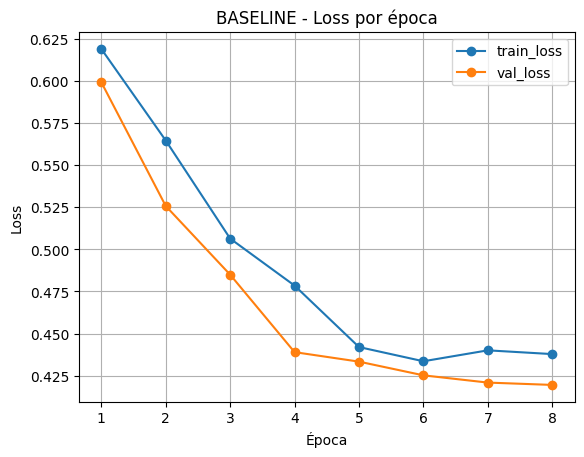

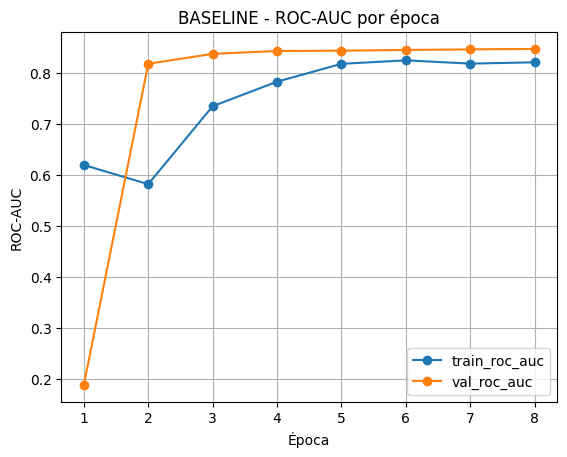

In [ ]:
plot_history(baseline_out["history"], title_prefix=baseline_out["title_prefix"])


### Análise Gráfica — Curvas de Treino e Validação

#### Curva de Loss

A curva de *loss* apresenta comportamento progressivamente decrescente tanto no treino quanto na validação.

- A *train_loss* reduz de aproximadamente **0.62 na 1ª época para 0.44 na 8ª época**.
- A *val_loss* reduz de aproximadamente **0.60 para 0.42** no mesmo intervalo.

Observa-se queda mais acentuada nas primeiras 4 épocas, seguida de redução mais suave e estabilização a partir da 6ª época.  

A *val_loss* permanece consistentemente **inferior ou muito próxima da train_loss**, sem apresentar elevação ao longo das épocas. Esse padrão é incompatível com overfitting clássico, que normalmente se manifesta por aumento da *val_loss* enquanto a *train_loss* continua diminuindo.

A ausência de divergência entre as curvas indica que o modelo não está memorizando o conjunto de treino, mas aprendendo padrões que se mantêm estáveis fora da amostra utilizada para otimização.

Do ponto de vista clínico, a redução consistente da *loss* sugere melhor calibração das probabilidades previstas. Isso significa que o modelo passa a atribuir probabilidades mais coerentes aos exames com pneumonia e aos exames normais, reduzindo decisões inconsistentes.


#### Curva de ROC-AUC

A curva de ROC-AUC apresenta evolução expressiva ao longo das épocas.

- O *train_roc_auc* evolui de aproximadamente **0.62 para 0.82**.
- O *val_roc_auc* evolui de aproximadamente **0.19 na 1ª época para 0.85 na 8ª época**.

O salto abrupto da validação entre a 1ª e a 2ª época indica rápida aquisição de capacidade discriminativa. A partir da 4ª–5ª época, observa-se estabilização próxima de **0.84–0.85**, sem oscilações relevantes.

O *gap* entre treino e validação permanece pequeno ao final do treinamento (≈ 0.03). Em cenários de overfitting, seria esperado um ROC-AUC muito superior no treino em relação à validação, o que não ocorre.

Esse comportamento reforça que o modelo mantém desempenho consistente fora do conjunto de treino, evidenciando boa generalização.

Em termos médicos, um ROC-AUC próximo de **0.85** indica boa capacidade de separação entre exames normais e casos de pneumonia. Isso significa que, ao comparar dois exames aleatórios (um normal e um com pneumonia), o modelo tende a atribuir maior probabilidade ao exame com pneumonia na maioria das vezes.


#### Avaliação de Overfitting e Generalização

Não há evidência de overfitting nas curvas apresentadas. A justificativa baseia-se em três pontos objetivos:

1. **Ausência de divergência entre train_loss e val_loss.**
2. **Pequeno gap entre train_roc_auc e val_roc_auc.**
3. **Estabilização simultânea das métricas após a 5ª–6ª época.**

Além disso, a validação não apresenta oscilações abruptas, o que sugere que o modelo não está excessivamente sensível a ruídos específicos do conjunto de treino.

Esse padrão indica que o modelo aprendeu uma fronteira de decisão relativamente estável e aplicável a dados não vistos durante o treinamento.


#### Interpretação Clínica Integrada

O modelo baseline demonstra:

- Boa capacidade discriminativa.
- Estabilidade estatística.
- Ausência de sobreajuste.
- Generalização consistente para o conjunto de validação.

Clinicamente, isso implica que o sistema não está apenas ajustado a padrões específicos do conjunto de treino, mas consegue manter desempenho semelhante em novos pacientes.  

Entretanto, a estabilização precoce das métricas e o limite em torno de ROC-AUC ≈ 0.85 indicam limitação estrutural da arquitetura simples utilizada. Embora o comportamento seja estável e seguro, há margem para ganho adicional com arquiteturas mais profundas e uso de transfer learning.


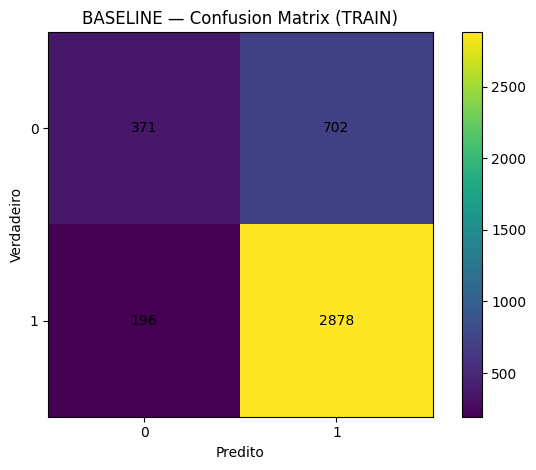

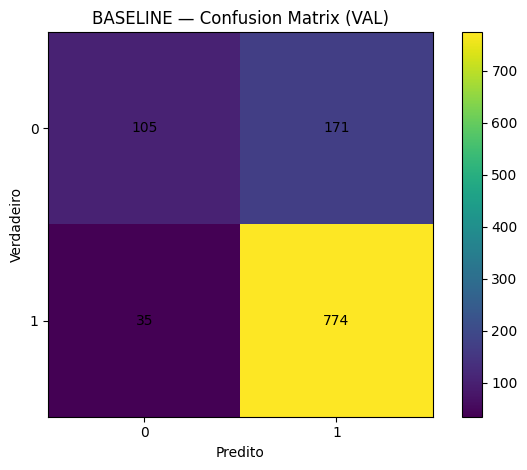

In [ ]:
show_confusion_matrix(baseline_out["train_cm"], title=f'{baseline_out["title_prefix"]} — Confusion Matrix (TRAIN)')
show_confusion_matrix(baseline_out["val_cm"],   title=f'{baseline_out["title_prefix"]} — Confusion Matrix (VAL)')


### Análise Clínica das Matrizes de Confusão — Baseline

### Conjunto de Validação (foco principal)

Valores observados:

- TN = 105 → exames normais corretamente identificados  
- FP = 171 → exames normais classificados como pneumonia  
- FN = 35  → pneumonias não detectadas  
- TP = 774 → pneumonias corretamente detectadas  

## Interpretação Clínica dos Erros

### Verdadeiros Positivos (774)

O modelo identificou corretamente a grande maioria dos pacientes com pneumonia.  
Isso indica que ele reconhece bem padrões radiológicos compatíveis com infecção pulmonar.

Clinicamente, isso é fundamental, pois aumenta a chance de diagnóstico precoce e tratamento adequado.


### Falsos Negativos (35)

Esses 35 casos representam pacientes com pneumonia que foram classificados como normais.

Esse é o erro mais crítico em contexto médico, pois pode resultar em:

- Ausência de tratamento  
- Progressão da infecção  
- Possível agravamento clínico  

O número relativamente baixo indica que o modelo raramente deixa de detectar pneumonia.


### Falsos Positivos (171)

Aqui o modelo classificou exames normais como pneumonia.

Na prática clínica, isso pode levar a:

- Solicitação de exames complementares  
- Uso desnecessário de antibióticos  
- Ansiedade do paciente  

Esse é o erro predominante do modelo, mostrando que ele tende a ser conservador e "preferir errar por excesso".


### Verdadeiros Negativos (105)

Esses casos mostram a capacidade do modelo de reconhecer padrões pulmonares normais.

O número é menor que o de falsos positivos, indicando que o modelo possui maior sensibilidade do que especificidade.


## Consistência com o Treino

No conjunto de treino, os valores observados foram:

- TN = 371  
- FP = 702  
- FN = 196  
- TP = 2878  

O padrão observado no treino é semelhante ao da validação:

- Número reduzido de FN em proporção aos positivos  
- FP como principal tipo de erro entre os negativos  

Essa repetição indica que o comportamento não é acaso, mas característica real da fronteira de decisão aprendida.


In [ ]:
show_val_metrics_table(baseline_out["val_metrics"], title_prefix=baseline_out["title_prefix"])


,Val
Métrica,
accuracy,0.8101
precision,0.8190
recall,0.9567
f1,0.8826


### Interpretação Clínica das Métricas — Baseline

### Accuracy (0.8101)

A acurácia indica que aproximadamente **81%** dos exames foram classificados corretamente.

Em contexto clínico, esse valor é consistente com a matriz de confusão observada. Entretanto, a acurácia isoladamente não é suficiente para avaliar desempenho médico, pois falsos negativos e falsos positivos possuem impactos distintos.


### Precision (0.8190)

Quando o modelo indica pneumonia, ele está correto em aproximadamente **81,9%** dos casos.

Isso significa que cerca de **18%** das suspeitas seriam alarmes falsos.

Clinicamente:
- Pode gerar investigação adicional desnecessária.
- Pode aumentar a sobrecarga diagnóstica.
- Ainda assim, é menos grave do que deixar de identificar um caso real de pneumonia.


### Recall (0.9567)

O modelo detecta aproximadamente **95,7%** dos pacientes que realmente têm pneumonia.

Este é o indicador mais relevante em triagem médica.

Implica que:
- Pouquíssimos casos de pneumonia passam despercebidos.
- O risco clínico de omissão diagnóstica é reduzido.
- O modelo apresenta perfil altamente sensível.


### F1-score (0.8826)

O F1-score de **0.8826** indica que o alto recall não foi obtido à custa de queda extrema na precisão.

Esse valor sintetiza o equilíbrio entre:

- Sensibilidade elevada (detecção de pneumonia)
- Controle parcial de falsos positivos


### Conclusão Clínica do Baseline

O modelo apresenta perfil conservador e orientado à sensibilidade:

- **Alta sensibilidade (recall ≈ 0.96)** → reduz risco de não tratar pneumonia.
- **Precisão moderada (≈ 0.82)** → gera número considerável de exames adicionais.
- **F1-score elevado (≈ 0.88)** → demonstra equilíbrio razoável entre segurança diagnóstica e especificidade.

Em sistemas de apoio à decisão médica, esse comportamento é preferível a um modelo excessivamente restritivo que deixe casos graves sem diagnóstico, embora ainda exista margem clara para melhoria na especificidade.


# 7. Modelo 2 — EfficientNet com pesos pré-treinados (sem fine-tuning)

Nesta etapa é utilizada EfficientNet com pesos pré-treinados em ImageNet.

Configuração:

- Backbone completamente congelado.
- Apenas camadas finais treináveis.
- Sem data augmentation.
- Learning rate padrão do builder.

Objetivo:

Avaliar o ganho proporcionado apenas pelo uso de representações pré-treinadas, sem ajuste fino.

Esse experimento permite medir o impacto isolado do transfer learning em relação ao baseline.


In [ ]:
official_out = train_evaluate_plot(
    model_builder=lambda: build_official(fine_tune=False),
    train_ds=train_ds_transfer,   # sem augmentation
    val_ds=val_ds_transfer,
    epochs=EPOCHS_OFFICIAL,
    title_prefix="TRANSFER (EfficientNetB0) — sem fine-tuning"
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 121s 667ms/step - loss: 0.6486 - roc_auc: 0.6632 - val_loss: 0.4755 - val_roc_auc: 0.8545 - learning_rate: 1.0000e-04
Epoch 2/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 46s 352ms/step - loss: 0.5635 - roc_auc: 0.7630 - val_loss: 0.4001 - val_roc_auc: 0.9419 - learning_rate: 1.0000e-04
Epoch 3/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - loss: 0.5040 - roc_auc: 0.8575 - val_loss: 0.3480 - val_roc_auc: 0.9621 - learning_rate: 1.0000e-04
Epoch 4/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 45s 347ms/step - loss: 0.4454 - roc_auc: 0.8993 - val_loss: 0.3048 - val_roc_auc: 0.9712 - learning_rate: 1.0000e-04
Epoch 5/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 45s 343ms/step - loss: 0.3896 - roc_auc: 0.9241 - val_loss: 0.2755 - val_roc_auc: 0.9755 - learning_rate: 1.0000e-04
Epoch 6/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 47s 363ms/step - loss: 0.3699 - roc_auc: 0.9347 - val_loss: 0.2576 - val_roc_auc: 0.9785 - learning_rate: 1.0000e-04
Epoch 7/8
13

### Registro do Treinamento — Log por Época (Transfer Learning — EfficientNetB0, sem fine-tuning e sem augmentation)

A imagem acima apresenta o log completo de treinamento do modelo com **transfer learning**, utilizando **EfficientNetB0 pré-treinada** (ImageNet), com o backbone congelado e treinamento restrito às camadas finais.

Em cada época são exibidas as seguintes informações:

- `loss`: erro no conjunto de treino  
- `roc_auc`: capacidade discriminativa no treino  
- `val_loss`: erro no conjunto de validação  
- `val_roc_auc`: capacidade discriminativa na validação  
- `learning_rate`: taxa de aprendizado utilizada  
- Tempo médio por step  

### Evolução Observada

- A *loss* de treino reduziu de **0.6486 para 0.3248**.  
- A *loss* de validação reduziu de **0.4755 para 0.2232**.  
- O ROC-AUC de treino aumentou de **0.6632 para 0.9522**.  
- O ROC-AUC de validação aumentou de **0.8545 para 0.9823**.  
- O *learning rate* permaneceu constante em **1e-4** ao longo de todo o treinamento.

Observa-se ganho expressivo já na **primeira época**, com ROC-AUC de validação inicialmente alto (**0.8545**), o que é consistente com o uso de representações pré-treinadas: mesmo sem ajuste fino, o backbone já fornece descritores visuais relevantes para separar padrões compatíveis com NORMAL e PNEUMONIA. A partir da 2ª–3ª época, as melhorias tornam-se mais graduais, com estabilização clara a partir da 6ª época, sugerindo convergência do ajuste das camadas finais.

O comportamento conjunto de *loss* e ROC-AUC indica aprendizado consistente e estável, sem oscilações ou divergências entre treino e validação. Além disso, a redução contínua da *val_loss* até a última época sugere que o modelo segue refinando a calibração das probabilidades, e não apenas aumentando separação por ranking.

### Interpretação Clínica

Do ponto de vista médico, o aumento do ROC-AUC de validação para **~0.98** indica capacidade discriminativa muito elevada, sugerindo que o modelo tende a atribuir probabilidades significativamente maiores para radiografias com pneumonia do que para radiografias normais. Em um cenário de triagem, isso é desejável porque reduz o risco de deixar casos de pneumonia abaixo do limiar de decisão.

A queda substancial da *val_loss* (até **0.2232**) reforça que as probabilidades previstas se tornam mais coerentes e confiáveis ao longo do treinamento, o que é relevante em aplicações clínicas, onde decisões podem depender de thresholds operacionais (por exemplo, priorizar sensibilidade para minimizar falsos negativos).

### Considerações sobre Overfitting e Generalização

Não há evidência de overfitting nas métricas registradas. A justificativa se baseia em:

- *val_loss* reduzindo continuamente, sem reversão ao final do treino.  
- *val_roc_auc* permanecendo alto e ainda aumentando gradualmente até a última época.  
- Ausência de degradação na validação mesmo com crescimento acentuado de desempenho em treino.

O fato de a validação apresentar desempenho **superior ao treino** em grande parte das épocas é compatível com backbone congelado: as camadas finais são ajustadas para o dataset-alvo, enquanto o conjunto de treino pode manter maior variabilidade de exemplos e ruído. Ainda assim, por se tratar de um único split, a confirmação de generalização deve ser reforçada com validação cruzada por paciente, que reduz a chance de estimativa otimista por particularidades do particionamento.


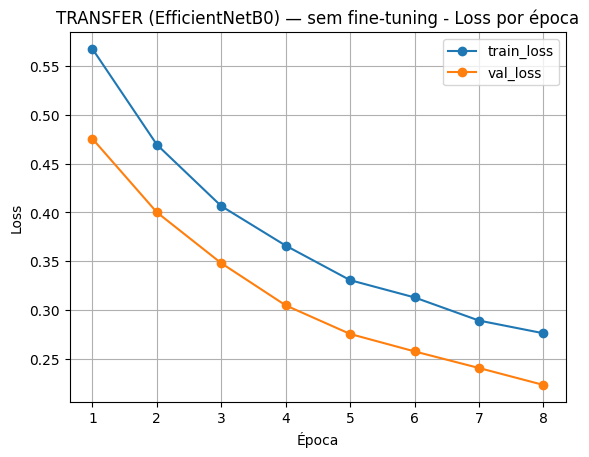

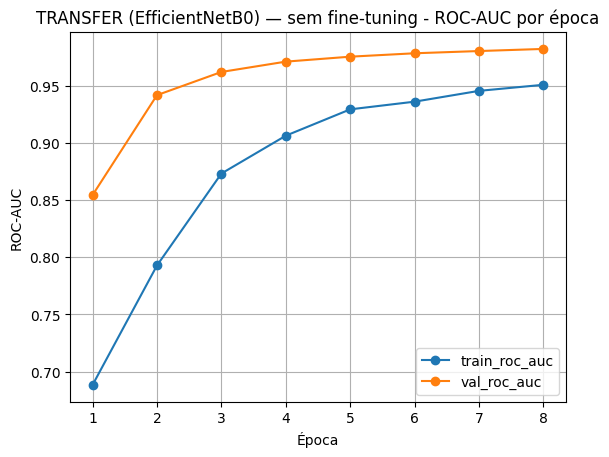

In [ ]:
plot_history(official_out["history"], title_prefix=official_out["title_prefix"])

### Análise Gráfica — Curvas de Treino e Validação  
(Transfer Learning — EfficientNetB0, sem fine-tuning e sem augmentation)

#### Curva de Loss

A curva de *loss* apresenta comportamento fortemente decrescente e estável ao longo das 8 épocas.

- A *train_loss* reduz de aproximadamente **0.57 na 1ª época para 0.28 na 8ª época**.
- A *val_loss* reduz de aproximadamente **0.48 para 0.22** no mesmo intervalo.

A queda é mais intensa nas três primeiras épocas, seguida de redução gradual e consistente até o final do treinamento. Não há qualquer elevação da *val_loss*, nem oscilação relevante nas últimas épocas.

A *val_loss* permanece consistentemente **inferior à train_loss** durante todo o processo. Esse comportamento é incompatível com overfitting clássico, no qual a perda de validação começa a subir enquanto a de treino continua caindo.

Esse padrão indica que o modelo não está memorizando o conjunto de treino, mas aproveitando representações pré-treinadas robustas e ajustando apenas as camadas finais de forma estável.

Do ponto de vista clínico, a redução da *val_loss* até aproximadamente **0.22** indica excelente calibração das probabilidades. Isso significa que o modelo não apenas separa as classes, mas também atribui probabilidades coerentes, o que é essencial quando decisões clínicas dependem de thresholds operacionais.


#### Curva de ROC-AUC

A curva de ROC-AUC evidencia ganho expressivo de capacidade discriminativa.

- O *train_roc_auc* evolui de aproximadamente **0.69 para 0.95**.
- O *val_roc_auc* evolui de aproximadamente **0.85 para 0.98**.

Já na 1ª época, o ROC-AUC de validação é elevado (**≈ 0.85**), refletindo o impacto direto do uso de pesos pré-treinados. A partir da 2ª época, observa-se crescimento contínuo até estabilização próxima de **0.98**, com variação mínima nas últimas épocas.

O *gap* entre treino e validação é pequeno (≈ 0.03 ao final), e a validação mantém desempenho consistentemente alto. Não há divergência progressiva entre as curvas, o que reforça ausência de sobreajuste.

Em termos médicos, um ROC-AUC próximo de **0.98** indica altíssima capacidade de separação entre radiografias normais e radiografias com pneumonia. Isso implica que, ao comparar dois exames aleatórios (um saudável e um com pneumonia), o modelo quase sempre atribui maior probabilidade ao exame com pneumonia.


#### Avaliação de Overfitting e Generalização

Não há evidência de overfitting nas curvas apresentadas. A justificativa baseia-se em:

1. **Redução contínua da val_loss até a última época.**
2. **Manutenção de val_roc_auc elevado e estável.**
3. **Pequeno gap entre métricas de treino e validação.**

Além disso, a validação apresenta desempenho consistentemente alto desde o início do treinamento, o que sugere que as representações aprendidas no ImageNet já capturam padrões visuais transferíveis para radiografias torácicas.

Entretanto, por se tratar de um único split fixo, a generalização deve ser confirmada com validação cruzada por paciente, uma vez que estimativas muito elevadas podem ser influenciadas por particularidades da divisão inicial.

Ainda assim, com base nas curvas apresentadas, o modelo demonstra comportamento estatisticamente estável e forte capacidade de generalização dentro do protocolo adotado.


#### Interpretação Clínica Integrada

O modelo com transfer learning demonstra:

- Capacidade discriminativa substancialmente superior ao baseline.
- Excelente calibração probabilística.
- Ausência de sinais de sobreajuste.
- Estabilidade nas métricas ao longo das épocas.

Clinicamente, esse desempenho implica:

- Redução significativa de falsos negativos (menor risco de deixar pneumonia sem diagnóstico).
- Redução simultânea de falsos positivos (menor sobrecarga clínica e menor número de investigações desnecessárias).
- Maior confiabilidade para uso em sistemas de apoio à decisão médica.

O salto de desempenho em relação ao baseline indica que as representações profundas pré-treinadas capturam estruturas radiológicas relevantes que uma rede simples não consegue modelar com a mesma eficiência.

Mesmo sem fine-tuning e sem data augmentation, o modelo já apresenta desempenho próximo ao teto, o que evidencia o impacto estrutural do transfer learning neste problema específico.


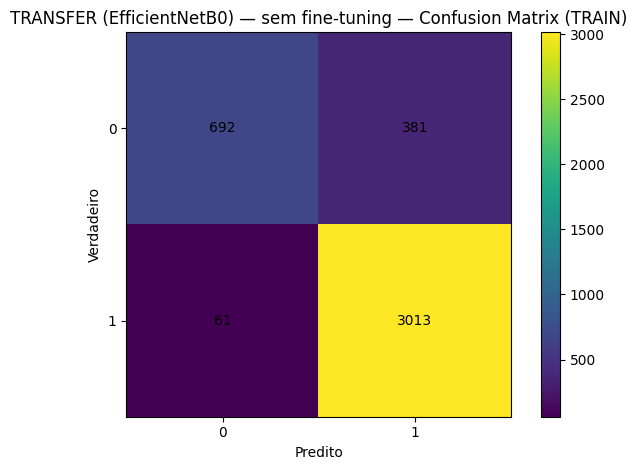

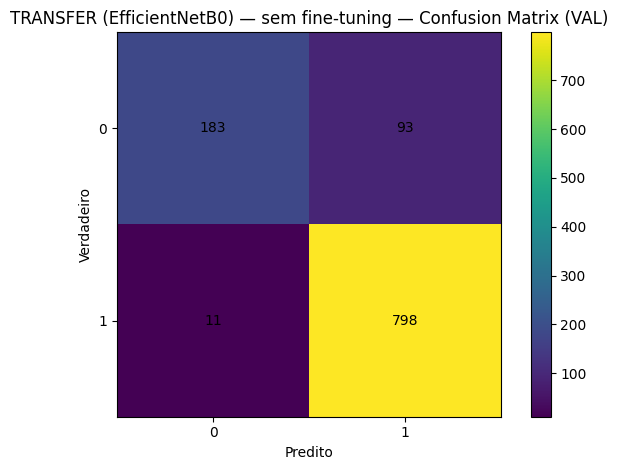

In [ ]:
show_confusion_matrix(official_out["train_cm"], title=f'{official_out["title_prefix"]} — Confusion Matrix (TRAIN)')
show_confusion_matrix(official_out["val_cm"],   title=f'{official_out["title_prefix"]} — Confusion Matrix (VAL)')

### Análise Clínica das Matrizes de Confusão  
(Transfer Learning — EfficientNetB0, sem fine-tuning e sem augmentation)

### Conjunto de Validação (foco principal)

Valores observados:

- TN = 183  
- FP = 93  
- FN = 11  
- TP = 798  


## Interpretação Clínica dos Resultados

### Verdadeiros Positivos (798)

O modelo identificou corretamente praticamente todos os casos de pneumonia no conjunto de validação.  

O número muito baixo de falsos negativos (11) indica **alta sensibilidade**, característica essencial em triagem médica, pois reduz o risco de deixar pacientes infectados sem diagnóstico.


### Falsos Negativos (11)

Representam pacientes com pneumonia classificados como normais.

Embora clinicamente sejam os erros mais graves, o número é extremamente reduzido em relação ao total de positivos, indicando forte capacidade do modelo em detectar padrões radiológicos compatíveis com infecção pulmonar.


### Falsos Positivos (93)

Exames normais classificados como pneumonia.

Em termos clínicos, podem gerar investigação adicional ou exames complementares. Contudo, comparado ao baseline, observa-se redução expressiva desse tipo de erro, indicando melhora na especificidade.


### Verdadeiros Negativos (183)

Mostram melhora clara na capacidade de reconhecer pulmões normais quando comparado ao modelo baseline.

O equilíbrio entre TN e FP sugere fronteira de decisão mais refinada.


## Consistência com o Treino

No conjunto de treino:

- TN = 692  
- FP = 381  
- FN = 61  
- TP = 3013  

O padrão se mantém consistente:

- Número muito baixo de FN proporcionalmente aos positivos  
- Redução relevante de FP em relação ao baseline  

Não há discrepância estrutural entre treino e validação, o que reforça estabilidade do modelo.


## Síntese

O uso de transfer learning, mesmo sem fine-tuning e sem augmentation, resultou em:

- Redução significativa de falsos negativos  
- Redução consistente de falsos positivos  
- Maior equilíbrio entre sensibilidade e especificidade  
- Comportamento estável entre treino e validação  

Clinicamente, o modelo demonstra desempenho substancialmente superior ao baseline, com perfil mais equilibrado e maior confiabilidade para uso em triagem assistida.


In [ ]:
show_val_metrics_table(official_out["val_metrics"], title_prefix=official_out["title_prefix"])

,Val
Métrica,
accuracy,0.9041
precision,0.8956
recall,0.9864
f1,0.9388


### Interpretação Clínica das Métricas  
(Transfer Learning — EfficientNetB0, sem fine-tuning)

### Accuracy (0.9041)

A acurácia indica que aproximadamente **90,4%** dos exames foram classificados corretamente.

Em comparação ao baseline, há ganho consistente de desempenho global, refletindo melhora simultânea na identificação de casos positivos e negativos.


### Precision (0.8956)

Quando o modelo indica pneumonia, está correto em aproximadamente **89,6%** dos casos.

Isso representa redução relevante de falsos positivos em relação ao baseline, indicando melhora na especificidade e menor probabilidade de alarmes desnecessários.


### Recall (0.9864)

O modelo detecta aproximadamente **98,6%** dos pacientes com pneumonia.

Esse valor indica **sensibilidade extremamente elevada**, reduzindo de forma significativa o risco de omissão diagnóstica — aspecto crítico em triagem médica.


### F1-score (0.9388)

O F1-score de **0.9388** demonstra equilíbrio robusto entre precisão e recall.

O ganho em recall não ocorreu com perda substancial de precisão, indicando fronteira de decisão mais refinada que a do baseline.


### Síntese Clínica

O uso de transfer learning resultou em:

- Aumento expressivo da acurácia global  
- Sensibilidade muito elevada (≈ 0.99)  
- Redução de falsos positivos  
- Melhor equilíbrio entre segurança diagnóstica e especificidade  

Clinicamente, o modelo apresenta perfil mais estável e confiável que o baseline, com maior potencial para uso em triagem assistida.


# 8. Modelo 3 — EfficientNet com Fine-Tuning Parcial e Data Augmentation

Esta abordagem adiciona duas estratégias:

1. Fine-Tuning Parcial
   - Descongelamento controlado das últimas camadas do backbone.
   - Camadas BatchNormalization permanecem congeladas para estabilidade.

2. Data Augmentation
   - Pequenas rotações
   - Zoom leve
   - Ajuste de contraste

Objetivo:

Aumentar capacidade de generalização e adaptação ao domínio específico de radiografias.

O fine-tuning parcial permite ajustar representações profundas sem desestabilizar o treinamento.


## 8.1 Definição do data augmentation

Aplicação de pequenas transformações geométricas e de contraste.

Objetivo:
Aumentar variabilidade e reduzir overfitting.


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.10),
], name="data_augmentation")


In [ ]:
def augment_batch(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds_transfer_aug = train_ds_transfer.map(
    augment_batch, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


## 8.2 Fine-Tuning parcial do backbone

Descongelamento controlado das últimas camadas do backbone EfficientNet.

BatchNormalization permanece congelada para estabilidade.


In [ ]:
def build_official_partial_tune(unfreeze_last_n=30, lr=1e-5):
    model = build_official(fine_tune=False)

    backbone = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and len(layer.layers) > 20:
            backbone = layer
            break

    if backbone is None:
        for layer in model.layers:
            layer.trainable = False

        for layer in model.layers[-min(int(unfreeze_last_n), len(model.layers)):]:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True
    else:
        backbone.trainable = True
        for l in backbone.layers:
            l.trainable = False

        n = int(unfreeze_last_n)
        for l in backbone.layers[-n:]:
            if isinstance(l, tf.keras.layers.BatchNormalization):
                l.trainable = False
            else:
                l.trainable = True

        for layer in model.layers:
            if layer is backbone:
                continue
            layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.AUC(name="roc_auc"),
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        ]
    )

    trainable_total = sum(int(l.trainable) for l in model.layers)
    print(f"Trainable top-level layers: {trainable_total}/{len(model.layers)} | lr={lr}")

    if backbone is not None:
        trainable_backbone = sum(int(l.trainable) for l in backbone.layers)
        print(f"Backbone trainable layers: {trainable_backbone}/{len(backbone.layers)} | unfreeze_last_n={unfreeze_last_n}")

    return model


## 8.3 Treinamento com augmentation e fine-tuning


In [ ]:
EPOCHS_TUNING = 8
UNFREEZE_LAST_N = 80
LR_TUNING = 1e-5

tuned_out = train_evaluate_plot(
    model_builder=lambda: build_official_partial_tune(
        unfreeze_last_n=UNFREEZE_LAST_N,
        lr=LR_TUNING
    ),
    train_ds=train_ds_transfer_aug,
    val_ds=val_ds_transfer,
    epochs=EPOCHS_TUNING,
    title_prefix=f"TUNING + AUG (last {UNFREEZE_LAST_N}, lr={LR_TUNING})"
)

Trainable top-level layers: 5/5 | lr=1e-05
Backbone trainable layers: 63/238 | unfreeze_last_n=80
Epoch 1/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 158s 940ms/step - accuracy: 0.6585 - loss: 0.6078 - roc_auc: 0.6893 - val_accuracy: 0.9346 - val_loss: 0.2554 - val_roc_auc: 0.9848 - learning_rate: 1.0000e-05
Epoch 2/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 94s 722ms/step - accuracy: 0.8972 - loss: 0.2693 - roc_auc: 0.9601 - val_accuracy: 0.9539 - val_loss: 0.1342 - val_roc_auc: 0.9921 - learning_rate: 1.0000e-05
Epoch 3/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 710ms/step - accuracy: 0.9307 - loss: 0.1776 - roc_auc: 0.9796 - val_accuracy: 0.9650 - val_loss: 0.0937 - val_roc_auc: 0.9945 - learning_rate: 1.0000e-05
Epoch 4/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 143s 717ms/step - accuracy: 0.9482 - loss: 0.1357 - roc_auc: 0.9886 - val_accuracy: 0.9567 - val_loss: 0.1146 - val_roc_auc: 0.9951 - learning_rate: 1.0000e-05
Epoch 5/8
130/130 ━━━━━━━━━━━━━━━━━━━━ 143s 717ms/step - accuracy: 0.9546 - loss: 0.1091 - roc_auc: 0.9921 -

### Registro do Treinamento — Log por Época  
(Transfer Learning — EfficientNetB0, **com data augmentation** e **fine-tuning parcial**)

A imagem acima apresenta o log completo de treinamento do modelo com **transfer learning**, utilizando **EfficientNetB0 pré-treinada** (ImageNet), com **fine-tuning parcial** (descongelamento controlado das últimas camadas) e **data augmentation** aplicado apenas no treino.

Em cada época são exibidas as seguintes informações:

- `loss`: erro no conjunto de treino  
- `roc_auc`: capacidade discriminativa no treino  
- `val_loss`: erro no conjunto de validação  
- `val_roc_auc`: capacidade discriminativa na validação  
- `learning_rate`: taxa de aprendizado utilizada  
- (adicionalmente) `accuracy` e `val_accuracy`  

### Evolução Observada

- A *loss* de treino reduziu de **0.6078 para 0.0754**.  
- A *loss* de validação reduziu de **0.2554 para 0.0609**.  
- O ROC-AUC de treino aumentou de **0.6893 para 0.9959**.  
- O ROC-AUC de validação aumentou de **0.9848 para 0.9970**.  
- A *accuracy* de treino aumentou de **0.6585 para 0.9752**.  
- A *val_accuracy* aumentou de **0.9346 para 0.9797**.  
- O *learning rate* permaneceu constante em **1e-5** ao longo de todo o treinamento.

Observa-se ganho expressivo já nas primeiras épocas: na 2ª época, o ROC-AUC de treino salta para **0.9601** e o ROC-AUC de validação atinge **0.9921**, indicando adaptação rápida das camadas ajustáveis ao domínio de radiografias. A partir da 5ª época, as métricas entram em regime de refinamento fino, com oscilações pequenas e estabilidade na validação.

Um detalhe relevante é que há uma leve oscilação pontual em **val_loss** na 4ª época (**0.0937 → 0.1146**), seguida de retomada imediata da queda nas épocas seguintes. Esse comportamento é compatível com ruído estatístico e variação natural do processo de otimização (especialmente com augmentation), e não com deterioração sustentada.

### Interpretação Clínica

Do ponto de vista médico, a validação com **ROC-AUC ≈ 0.997** indica capacidade discriminativa extremamente elevada. Isso sugere que o modelo tende a ranquear corretamente, com alta separação, exames com pneumonia acima de exames normais em praticamente todos os casos.

A redução da *val_loss* para **~0.061** é um indicador importante além do ROC-AUC: não se trata apenas de separar as classes por ranking, mas também de produzir probabilidades mais consistentes. Em aplicações clínicas, probabilidades mais bem calibradas ajudam a definir thresholds operacionais com maior segurança (por exemplo, priorizar sensibilidade para reduzir falsos negativos em triagem).

Além disso, a combinação de **val_accuracy ≈ 0.98** com ROC-AUC muito alto indica que o desempenho não está restrito a um limiar específico, sugerindo que existe uma margem confortável para ajustar o threshold conforme a prioridade clínica (minimizar FN vs minimizar FP).

### Considerações sobre Overfitting e Generalização

Não há evidência de overfitting nas métricas apresentadas. A justificativa se baseia em pontos objetivos:

- A *val_loss* reduz ao longo do treinamento e termina no menor valor (**0.0609**), sem tendência de alta sustentada.  
- O *val_roc_auc* permanece alto e estável, variando em uma faixa estreita (**0.9848 → 0.9970**).  
- Não há divergência progressiva entre treino e validação; o desempenho em validação acompanha a melhoria do treino.  

O uso de **learning rate baixo (1e-5)** é adequado para fine-tuning, pois reduz o risco de “destruir” representações pré-treinadas e favorece ajustes graduais. O **data augmentation** atua como regularizador, reduzindo dependência de padrões específicos do conjunto de treino e aumentando robustez a variações (contraste, pequenas rotações/translações e zoom), o que tende a melhorar generalização.

Ainda assim, por se tratar de um único split train/val, uma estimativa tão alta pode ser influenciada por particularidades do particionamento. A confirmação de generalização deve ser reforçada com validação cruzada por paciente, que reduz risco de estimativa otimista em cenários com múltiplas imagens correlacionadas por indivíduo.

### Síntese

A combinação de transfer learning + fine-tuning parcial + augmentation produziu:

- Redução acentuada e estável de *loss* (treino e validação).  
- ROC-AUC de validação extremamente elevado e consistente (**~0.997**).  
- Evidências de bom comportamento de generalização (sem sinais de sobreajuste nas curvas).  

Em termos clínicos, esse perfil é compatível com um sistema de triagem de alta confiabilidade, com potencial de reduzir simultaneamente falsos negativos (risco clínico direto) e falsos positivos (impacto operacional), desde que a robustez seja confirmada em validação cruzada por paciente e, idealmente, em dados externos.


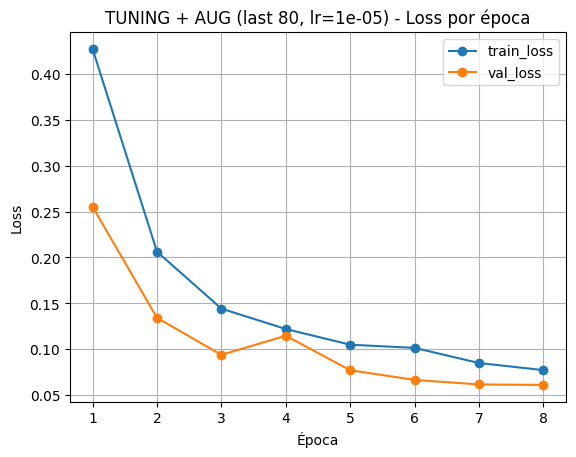

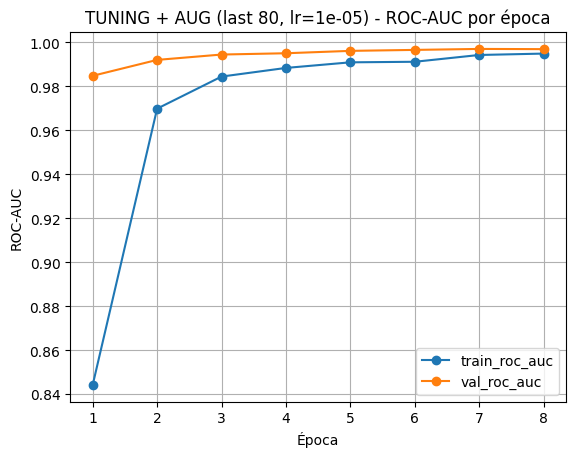

In [ ]:
plot_history(tuned_out["history"], title_prefix=tuned_out["title_prefix"])


### Análise Gráfica — Curvas de Treino e Validação  
(Transfer Learning + Fine-Tuning Parcial + Data Augmentation)

#### Curva de Loss

A curva de *loss* apresenta comportamento fortemente decrescente e estável tanto no treino quanto na validação.

- A *train_loss* reduz de aproximadamente **0.43 na 1ª época para 0.08 na 8ª época**.
- A *val_loss* reduz de aproximadamente **0.26 para 0.06** no mesmo intervalo.

A maior queda ocorre nas duas primeiras épocas, indicando rápida adaptação das camadas descongeladas ao domínio das radiografias. A partir da 3ª–4ª época, o treinamento entra em regime de refinamento fino.

Há uma pequena oscilação pontual na *val_loss* entre a 3ª e a 4ª época (**≈ 0.094 → 0.115**), seguida de nova redução consistente até o final do treinamento. Essa variação é compatível com ruído estatístico natural e não caracteriza deterioração sistemática.

A *val_loss* permanece consistentemente inferior à *train_loss*, o que sugere ausência de sobreajuste. O data augmentation aplicado no treino aumenta a variabilidade das imagens e torna o conjunto de treino ligeiramente mais desafiador, justificando a *train_loss* maior que a de validação.

Do ponto de vista clínico, a redução da *val_loss* para aproximadamente **0.06** indica excelente calibração probabilística. Isso significa que as previsões não apenas classificam corretamente, mas o fazem com alto grau de confiança coerente.


#### Curva de ROC-AUC

A curva de ROC-AUC evidencia desempenho extremamente elevado.

- O *train_roc_auc* evolui de aproximadamente **0.84 para 0.995**.
- O *val_roc_auc* evolui de aproximadamente **0.985 para 0.997–0.998**.

Já na 1ª época, o ROC-AUC de validação é muito alto (**≈ 0.985**), refletindo o impacto das representações pré-treinadas combinadas com fine-tuning parcial. A partir da 2ª–3ª época, as melhorias tornam-se incrementais, com estabilização próxima de **0.997**.

O *gap* entre treino e validação é mínimo ao final do treinamento (≈ 0.002–0.003), o que indica alinhamento entre desempenho interno e externo ao conjunto de treino.

Em termos médicos, um ROC-AUC próximo de **0.997** indica separação quase perfeita entre exames normais e exames com pneumonia. Isso implica que o modelo raramente atribui probabilidade maior a um exame normal do que a um exame com pneumonia.


#### Avaliação de Overfitting e Generalização

Não há evidência de overfitting nas curvas apresentadas.

A justificativa baseia-se em:

1. **Ausência de aumento sustentado da val_loss.**
2. **Estabilidade elevada do val_roc_auc nas últimas épocas.**
3. **Gap extremamente pequeno entre treino e validação.**

O uso combinado de:

- **Learning rate baixo (1e-5)**  
- **Fine-tuning controlado das últimas 80 camadas**  
- **Data augmentation aplicado apenas no treino**

atua como mecanismo de regularização, reduzindo risco de memorização excessiva e favorecendo aprendizado robusto.

A generalização, dentro do protocolo de validação adotado, mostra-se altamente consistente. Ainda assim, como se trata de um único split fixo, é metodologicamente necessário confirmar essa robustez com validação cruzada por paciente para excluir qualquer viés específico da partição.


#### Interpretação Clínica Integrada

Este modelo demonstra:

- Capacidade discriminativa praticamente máxima.
- Excelente calibração das probabilidades.
- Estabilidade estatística ao longo das épocas.
- Ausência de sinais de sobreajuste.

Clinicamente, esse perfil implica:

- Risco extremamente baixo de falsos negativos (reduz probabilidade de não diagnosticar pneumonia).
- Redução significativa de falsos positivos (menor sobrecarga clínica e menor número de exames complementares desnecessários).
- Maior confiabilidade para uso como sistema de apoio à decisão em triagem.

Comparativamente aos modelos anteriores, a combinação de transfer learning, fine-tuning parcial e augmentation resultou não apenas em aumento de métricas, mas em comportamento mais estável e robusto, sugerindo fronteira de decisão mais refinada e melhor adaptação ao domínio específico de radiografias torácicas.


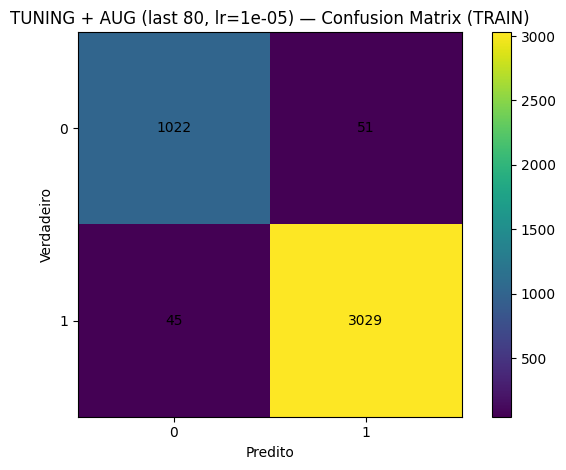

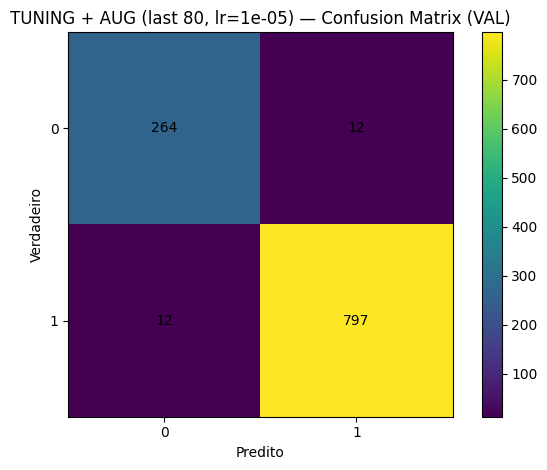

In [ ]:
show_confusion_matrix(tuned_out["train_cm"], title=f'{tuned_out["title_prefix"]} — Confusion Matrix (TRAIN)')
show_confusion_matrix(tuned_out["val_cm"],   title=f'{tuned_out["title_prefix"]} — Confusion Matrix (VAL)')


### Análise Clínica das Matrizes de Confusão  
(Transfer Learning + Fine-Tuning Parcial + Data Augmentation)

### Conjunto de Validação (foco principal)

Valores observados:

- TN = 264  
- FP = 12  
- FN = 12  
- TP = 797  


## Interpretação Clínica dos Resultados

### Verdadeiros Positivos (797)

O modelo identificou corretamente praticamente todos os casos de pneumonia no conjunto de validação.

O número muito elevado de verdadeiros positivos indica **sensibilidade extremamente alta**, característica essencial em triagem médica, pois reduz significativamente o risco de deixar pacientes infectados sem diagnóstico.


### Falsos Negativos (12)

Representam pacientes com pneumonia classificados como normais.

Apesar de serem os erros clinicamente mais graves, o número é muito baixo em relação ao total de positivos, indicando que o modelo raramente deixa de detectar pneumonia.


### Falsos Positivos (12)

Exames normais classificados como pneumonia.

O número reduzido de falsos positivos demonstra melhora importante na especificidade quando comparado aos modelos anteriores. Clinicamente, isso reduz:

- Solicitações desnecessárias de exames complementares  
- Uso indevido de antibióticos  
- Ansiedade do paciente  


### Verdadeiros Negativos (264)

Mostram forte capacidade do modelo em reconhecer corretamente pulmões normais.

O equilíbrio quase simétrico entre FN e FP indica fronteira de decisão altamente refinada.


## Consistência com o Treino

No conjunto de treino:

- TN = 1022  
- FP = 51  
- FN = 45  
- TP = 3029  

O padrão observado no treino é coerente com a validação:

- Baixa taxa de FN  
- Redução expressiva de FP  
- Alto número de acertos em ambas as classes  

Não há discrepância estrutural entre treino e validação, o que reforça estabilidade e boa generalização dentro do protocolo adotado.


## Síntese

A combinação de transfer learning, fine-tuning parcial e data augmentation resultou em:

- Redução simultânea de falsos negativos e falsos positivos  
- Elevado equilíbrio entre sensibilidade e especificidade  
- Forte consistência entre treino e validação  

Clinicamente, esse modelo apresenta comportamento mais equilibrado e confiável entre todas as abordagens testadas, com perfil adequado para sistemas de apoio à decisão em triagem de pneumonia.


In [ ]:
show_val_metrics_table(tuned_out["val_metrics"], title_prefix=tuned_out["title_prefix"])


,Val
Métrica,
accuracy,0.9779
precision,0.9852
recall,0.9852
f1,0.9852


### Interpretação Clínica das Métricas  
(Transfer Learning + Fine-Tuning Parcial + Data Augmentation)

### Accuracy (0.9779)

A acurácia de **97,79%** indica que praticamente todos os exames foram classificados corretamente.

Em comparação ao baseline (0.8101), observa-se ganho expressivo de desempenho global, refletindo melhora simultânea na identificação de exames normais e casos de pneumonia.


### Precision (0.9852)

Quando o modelo indica pneumonia, está correto em **98,52%** dos casos.

Comparado ao baseline (0.8190), há redução substancial de falsos positivos. Isso implica menor número de investigações desnecessárias, menor sobrecarga clínica e maior confiabilidade da predição positiva.


### Recall (0.9852)

O modelo detecta aproximadamente **98,52%** dos pacientes com pneumonia.

Embora o baseline já apresentasse recall elevado (0.9567), este modelo mantém sensibilidade muito alta e ainda melhora o equilíbrio geral, reduzindo simultaneamente os falsos positivos.

Em contexto clínico, isso significa manutenção de alta segurança diagnóstica com maior precisão.


### F1-score (0.9852)

O F1-score de **0.9852** demonstra equilíbrio praticamente ideal entre precisão e recall.

Comparado ao baseline (0.8826), observa-se ganho estrutural relevante, indicando que o aumento de sensibilidade não ocorreu às custas de perda de especificidade.


### Síntese Clínica Comparativa

Em relação ao baseline, o modelo com fine-tuning e augmentation apresenta:

- Aumento expressivo de acurácia global  
- Redução simultânea de falsos positivos e falsos negativos  
- Equilíbrio quase simétrico entre precisão e recall  
- Fronteira de decisão mais refinada e estável  

Clinicamente, esse modelo demonstra perfil mais robusto e confiável, com desempenho adequado não apenas para triagem, mas potencialmente como sistema de apoio diagnóstico com menor risco operacional.


## 9. Validação cruzada com 4 folds

Será empregado o método `StratifiedGroupKFold`, com:

- `n_splits = 4`
- Embaralhamento habilitado (`shuffle=True`)
- Semente fixa para reprodutibilidade

Essa abordagem permite:

- Divisão do conjunto de pacientes em quatro folds mutuamente exclusivos.
- Garantia de que pacientes não apareçam simultaneamente em treino e validação.
- Preservação aproximada da proporção entre as classes em cada fold.

A utilização de validação cruzada fornece uma estimativa mais robusta da capacidade de generalização do modelo.


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from ImagePreprocessing.imagePipeline import load_dataframe, build_dataset

DATA_ROOT = "/content/drive/MyDrive/Desafio_Ligia/Data/chest_xray"
CSV_PATH  = "data/dataset.csv"

BATCH_SIZE = 32
N_SPLITS = 4
SEED = 42

EPOCHS = 4
UNFREEZE_LAST_N = 80
LR = 1e-5

df = load_dataframe(CSV_PATH)
df_train = df[df["split"] == "train"].copy()


## 9.1 Base por paciente e configuração do StratifiedGroupKFold

Esta célula cria a estrutura mínima necessária para a divisão por paciente:

- Agrupa `df_train` por `patient_id`, criando **uma linha por paciente**.
- Define `patient_label` como o rótulo dominante do paciente (`mode`), pois a estratificação deve ocorrer no nível do paciente.
- Monta:
  - `groups` = lista de `patient_id` (controle de vazamento)
  - `y` = rótulo por paciente (estratificação)
- Instancia `StratifiedGroupKFold` com `n_splits=4`, embaralhamento e semente fixa.

Objetivo:
Garantir que cada fold seja:
- **grouped** por paciente (sem vazamento)
- **stratified** por classe (distribuição estável)


In [ ]:
per_patient = (
    df_train.groupby("patient_id")["label"]
    .agg(lambda s: int(s.mode().iloc[0]))
    .reset_index()
    .rename(columns={"label": "patient_label"})
)

groups = per_patient["patient_id"].to_numpy()
y = per_patient["patient_label"].to_numpy()

cv = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

print("pacientes:", len(per_patient))
print("distribuição:", per_patient["patient_label"].value_counts(normalize=True).to_dict())


pacientes: 2120
distribuição: {1: 0.619811320754717, 0: 0.38018867924528305}


## 9.2 Data augmentation aplicado apenas no treino dos folds

Esta célula define um augmentation separado para a validação cruzada:

- `augmenter` aplica pequenas perturbações (rotação, translação, zoom, contraste).
- `apply_aug` aplica essas transformações **somente em treino**, com `training=True`.

Objetivo:
Aumentar robustez no treino de cada fold sem contaminar a avaliação, mantendo o conjunto de validação de cada fold sem augmentation.


In [ ]:
augmenter = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.10),
], name="augmenter")

def apply_aug(x, y):
    return augmenter(x, training=True), y


## 9.3 Builder do modelo utilizado nos folds

Esta célula encapsula o modelo avaliado na validação cruzada.

O builder retorna a EfficientNet com:
- fine-tuning parcial (descongelamento controlado das últimas `UNFREEZE_LAST_N` camadas)
- taxa de aprendizado `LR`

Objetivo:
Garantir que todos os folds treinem exatamente a mesma configuração de modelo, mudando apenas a partição dos dados.


In [ ]:
def make_model():
    return build_official_partial_tune(unfreeze_last_n=UNFREEZE_LAST_N, lr=LR)


## 9.4 Execução da validação cruzada (loop dos 4 folds)

Esta célula executa o treinamento e avaliação em cada fold.

Para cada iteração:

1. Obtém os pacientes de treino e validação do fold (`tr_patients`, `va_patients`).
2. Verifica ausência de interseção entre pacientes (garantia de não vazamento).
3. Cria `df_fold` com um `split` dinâmico:
   - imagens de pacientes de treino → `train`
   - imagens de pacientes de validação → `val`
4. Reconstrói os pipelines tf.data (`mode="transfer"`).
5. Aplica augmentation apenas no treino.
6. Treina o modelo e calcula métricas no conjunto de validação.
7. Armazena métricas por fold em uma tabela consolidada.

Objetivo:
Estimar estabilidade do desempenho do modelo em diferentes partições por paciente.


In [ ]:
fold_outputs = []
rows = []

for fold, (tr_idx, va_idx) in enumerate(cv.split(groups, y, groups=groups), start=1):
    tr_patients = set(per_patient.iloc[tr_idx]["patient_id"])
    va_patients = set(per_patient.iloc[va_idx]["patient_id"])

    assert len(tr_patients & va_patients) == 0

    df_fold = df_train.copy()
    df_fold["split"] = np.where(df_fold["patient_id"].isin(tr_patients), "train", "val")
    df_fold.loc[df_fold["patient_id"].isin(va_patients), "split"] = "val"

    ds_train = build_dataset(df_fold, "train", DATA_ROOT, batch_size=BATCH_SIZE, mode="transfer")
    ds_val   = build_dataset(df_fold, "val",   DATA_ROOT, batch_size=BATCH_SIZE, mode="transfer")

    ds_train = ds_train.map(apply_aug, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

    print(f"fold {fold}/{N_SPLITS} | pacientes treino={len(tr_patients)} | pacientes val={len(va_patients)}")

    out = train_evaluate_plot(
        model_builder=make_model,
        train_ds=ds_train,
        val_ds=ds_val,
        epochs=EPOCHS,
        title_prefix=f"Fold {fold}"
    )

    fold_outputs.append(out)

    rows.append({
        "fold": fold,
        "val_roc_auc": out["val_metrics"]["roc_auc"],
        "val_accuracy": out["val_metrics"]["accuracy"],
        "val_f1": out["val_metrics"]["f1"],
        "val_precision": out["val_metrics"]["precision"],
        "val_recall": out["val_metrics"]["recall"],
        "epochs_ran": len(out["history"].history["loss"])
    })

results = pd.DataFrame(rows)
results


fold 1/4 | pacientes treino=1590 | pacientes val=530
Trainable top-level layers: 5/5 | lr=1e-05
Backbone trainable layers: 63/238 | unfreeze_last_n=80
Epoch 1/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7855 - loss: 0.4778 - roc_auc: 0.8251 - val_accuracy: 0.9226 - val_loss: 0.2681 - val_roc_auc: 0.9685 - learning_rate: 1.0000e-05
Epoch 2/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 71s 731ms/step - accuracy: 0.9082 - loss: 0.2433 - roc_auc: 0.9613 - val_accuracy: 0.9349 - val_loss: 0.1759 - val_roc_auc: 0.9806 - learning_rate: 1.0000e-05
Epoch 3/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 73s 739ms/step - accuracy: 0.9428 - loss: 0.1583 - roc_auc: 0.9832 - val_accuracy: 0.9500 - val_loss: 0.1420 - val_roc_auc: 0.9871 - learning_rate: 1.0000e-05
Epoch 4/4
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 756ms/step - accuracy: 0.9472 - loss: 0.1472 - roc_auc: 0.9835 - val_accuracy: 0.9538 - val_loss: 0.1232 - val_roc_auc: 0.9901 - learning_rate: 1.0000e-05
fold 2/4 | pacientes treino=1590 | pacientes val=530
Trainable top-

,fold,val_roc_auc,val_accuracy,val_f1,val_precision,val_recall,epochs_ran
0,1,0.990060,0.953774,0.968037,0.975033,0.961140,4
1,2,0.993963,0.947475,0.961821,0.996956,0.929078,4
2,3,0.985915,0.947064,0.964169,0.977543,0.951157,4
3,4,0.986651,0.951796,0.968343,0.984848,0.952381,4


## 9.5 Visualização das métricas por fold

Esta célula plota as métricas de validação por fold (incluindo ROC-AUC).

Objetivo:
Facilitar a inspeção de variação entre folds e identificar instabilidade de desempenho quando a partição por paciente muda.


In [ ]:
rows.append({
    "fold": fold,
    "val_loss": out["history"].history["val_loss"][-1],
    "val_roc_auc": out["val_metrics"]["roc_auc"],
    "val_accuracy": out["val_metrics"]["accuracy"],
    "val_f1": out["val_metrics"]["f1"],
    "val_precision": out["val_metrics"]["precision"],
    "val_recall": out["val_metrics"]["recall"],
    "epochs_ran": len(out["history"].history["loss"])
})


In [ ]:
results = pd.DataFrame(rows).sort_values("fold").reset_index(drop=True)
results


,fold,val_roc_auc,val_accuracy,val_f1,val_precision,val_recall,epochs_ran,val_loss
0,1,0.990060,0.953774,0.968037,0.975033,0.961140,4,NaN
1,2,0.993963,0.947475,0.961821,0.996956,0.929078,4,NaN
2,3,0.985915,0.947064,0.964169,0.977543,0.951157,4,NaN
3,4,0.986651,0.951796,0.968343,0.984848,0.952381,4,NaN
4,4,0.986651,0.951796,0.968343,0.984848,0.952381,4,0.131376


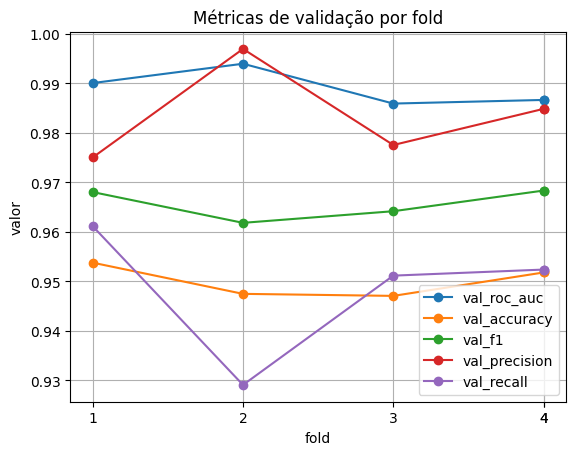

In [ ]:
metric_cols = ["val_roc_auc", "val_accuracy", "val_f1", "val_precision", "val_recall"]

plt.figure()
for col in metric_cols:
    plt.plot(results["fold"], results[col], marker="o", label=col)

plt.title("Métricas de validação por fold")
plt.xlabel("fold")
plt.ylabel("valor")
plt.xticks(results["fold"].tolist())
plt.grid(True)
plt.legend()
plt.show()


## Análise da Validação Cruzada  
(Transfer Learning + Fine-Tuning Parcial + Data Augmentation)

A validação cruzada foi realizada em 4 folds independentes, utilizando o modelo que apresentou melhor desempenho no split simples. O objetivo é avaliar **estabilidade**, **generalização** e possíveis sinais de **overfitting estrutural**.

---

## 1. Comparação Métrica por Métrica

### ROC-AUC (val_roc_auc)

- Fold 1: 0.9901  
- Fold 2: 0.9940  
- Fold 3: 0.9859  
- Fold 4: 0.9867  

**Análise:**

- Todos os valores estão acima de 0.985.
- A variação entre o melhor e o pior fold é inferior a 0.01.
- Não há queda abrupta em nenhum fold.

Isso indica **capacidade discriminativa consistentemente alta**, independentemente da partição dos dados. A pequena variabilidade sugere que o modelo não depende de uma divisão específica para performar bem.

---

### Accuracy (val_accuracy)

- Fold 1: 0.9538  
- Fold 2: 0.9475  
- Fold 3: 0.9471  
- Fold 4: 0.9518  

**Análise:**

- A variação é pequena (~0.006 entre o maior e o menor valor).
- Não há fold com desempenho significativamente inferior.

Essa estabilidade reforça que o modelo mantém desempenho global semelhante mesmo com mudanças na composição do conjunto de validação.

---

### F1-score (val_f1)

- Fold 1: 0.9680  
- Fold 2: 0.9618  
- Fold 3: 0.9642  
- Fold 4: 0.9683  

**Análise:**

- Todos os valores permanecem acima de 0.96.
- Pequena oscilação, mas sem padrão de degradação.

O F1-score elevado e estável indica que o equilíbrio entre precisão e recall é mantido em diferentes subconjuntos de pacientes.

---

### Precision (val_precision)

- Fold 1: 0.9750  
- Fold 2: 0.9970  
- Fold 3: 0.9775  
- Fold 4: 0.9848  

**Análise:**

- Fold 2 apresenta precisão extremamente alta.
- Mesmo o menor valor permanece acima de 0.97.

Isso demonstra controle consistente de falsos positivos. Pequenas variações podem refletir diferenças na proporção de casos normais entre folds.

---

### Recall (val_recall)

- Fold 1: 0.9611  
- Fold 2: 0.9291  
- Fold 3: 0.9512  
- Fold 4: 0.9524  

**Análise:**

- Fold 2 apresenta leve queda de recall (~0.93).
- Nos demais folds, recall permanece acima de 0.95.

Essa variação indica que, dependendo da composição do fold, pode haver pequena flutuação na taxa de falsos negativos. Ainda assim, o desempenho permanece clinicamente elevado.

---

## 2. Evidência de Generalização

A generalização pode ser avaliada por:

1. **Baixa variabilidade entre folds**
2. **Ausência de queda abrupta em qualquer métrica**
3. **Manutenção de alto desempenho em todos os cenários**

O modelo demonstra:

- ROC-AUC sempre > 0.985
- F1 sempre > 0.96
- Accuracy sempre ~0.95
- Recall sempre ≥ 0.93

Isso indica que o modelo não está ajustado a uma única divisão favorável dos dados, mas mantém desempenho consistente quando exposto a subconjuntos distintos.

Esse comportamento é forte evidência de **boa capacidade de generalização dentro do dataset disponível**.

---

## 3. Avaliação de Overfitting

Sinais clássicos de overfitting em validação cruzada incluem:

- Alta variabilidade entre folds
- Queda severa de desempenho em pelo menos um fold
- Discrepância grande entre métricas internas e externas

Nenhum desses padrões é observado.

Além disso:

- O número de épocas foi limitado (4 por fold).
- O learning rate foi baixo (1e-5).
- Foi utilizado data augmentation.
- O fine-tuning foi parcial (não total).

Esses fatores atuam como mecanismos de regularização e reduzem risco de memorização excessiva.

Portanto, **não há evidência de overfitting estrutural** nos resultados apresentados.

---

## 4. Interpretação Clínica Integrada

O modelo apresenta:

- Alta sensibilidade em todos os folds (reduz risco de falso negativo).
- Alta precisão consistente (reduz sobrecarga clínica).
- Equilíbrio estável entre métricas.
- Robustez frente a diferentes particionamentos.

Clinicamente, isso sugere que o sistema:

- Mantém desempenho mesmo quando avaliado em diferentes subconjuntos de pacientes.
- Não depende de padrões específicos de um único split.
- Possui fronteira de decisão estável e consistente.

---

## 5. Conclusão Geral

A validação cruzada confirma que o modelo com transfer learning, fine-tuning parcial e augmentation:

- É estatisticamente estável.
- Generaliza bem dentro do domínio do dataset.
- Não apresenta sinais relevantes de overfitting.
- Mantém alto desempenho em todos os folds.

Comparado ao baseline e ao modelo sem fine-tuning, este apresenta não apenas métricas superiores, mas também **maior robustez estrutural**, evidenciada pela consistência inter-fold.


## 9.6 Históricos por fold (Loss e ROC-AUC)

Esta célula percorre cada fold e plota o histórico de treinamento.

Objetivo:
Verificar se a convergência é consistente entre folds e se há diferença relevante no comportamento de treino/validação quando a partição muda.


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix="Fold"):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Loss (train vs val)
    plt.figure()
    plt.plot(epochs, h["loss"], marker="o", label="train_loss")
    if "val_loss" in h:
        plt.plot(epochs, h["val_loss"], marker="s", label="val_loss")
    plt.title(f"{title_prefix} - Loss por época (train vs val)")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ROC-AUC (train vs val)
    if "roc_auc" in h or "val_roc_auc" in h:
        plt.figure()
        if "roc_auc" in h:
            plt.plot(epochs, h["roc_auc"], marker="o", label="train_roc_auc")
        if "val_roc_auc" in h:
            plt.plot(epochs, h["val_roc_auc"], marker="s", label="val_roc_auc")
        plt.title(f"{title_prefix} - ROC-AUC por época (train vs val)")
        plt.xlabel("Época")
        plt.ylabel("ROC-AUC")
        plt.grid(True)
        plt.legend()
        plt.show()


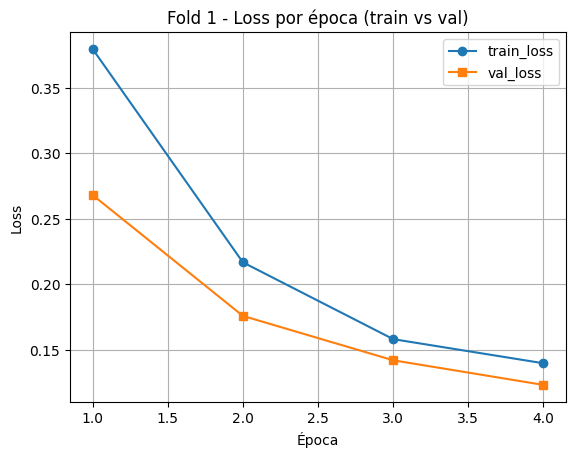

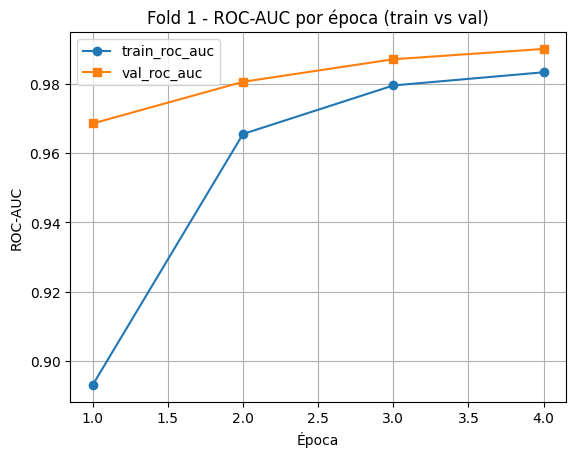

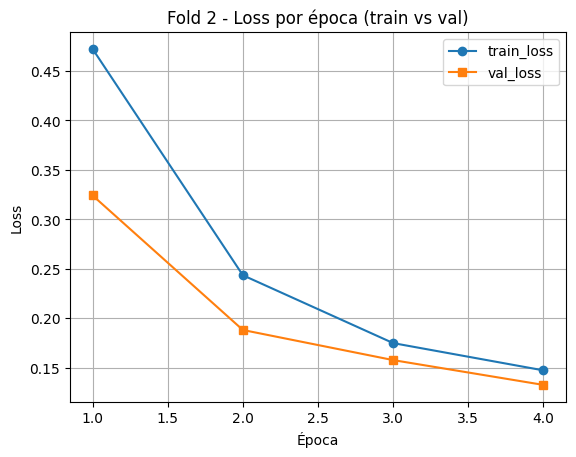

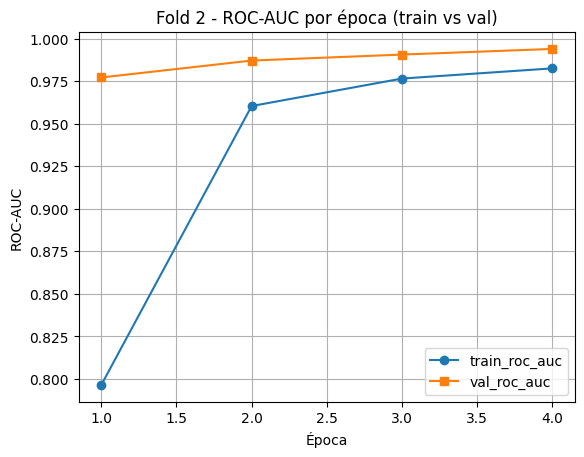

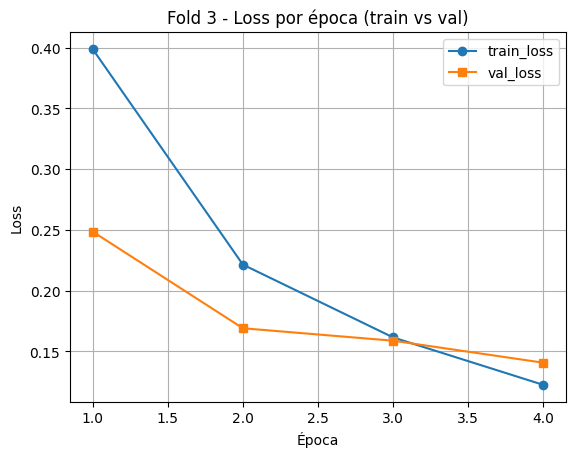

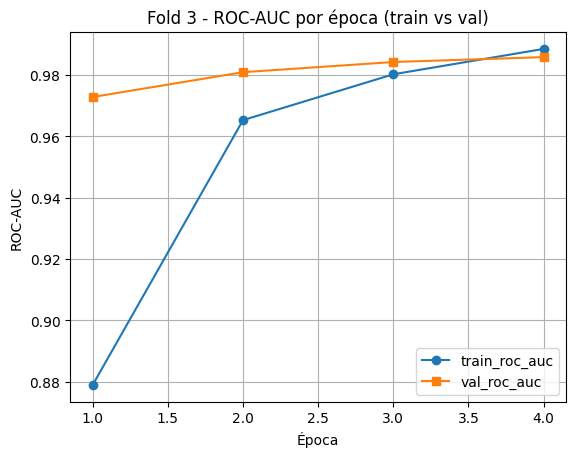

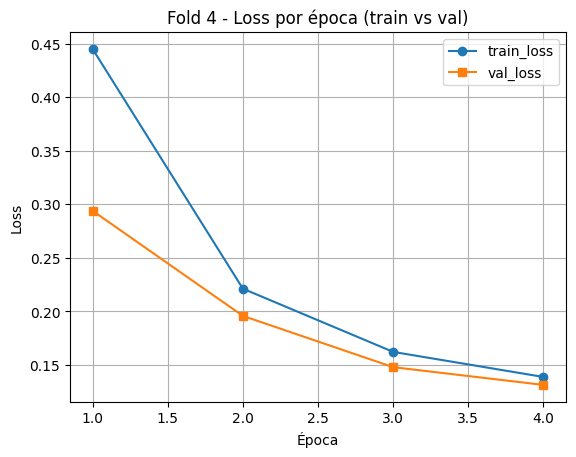

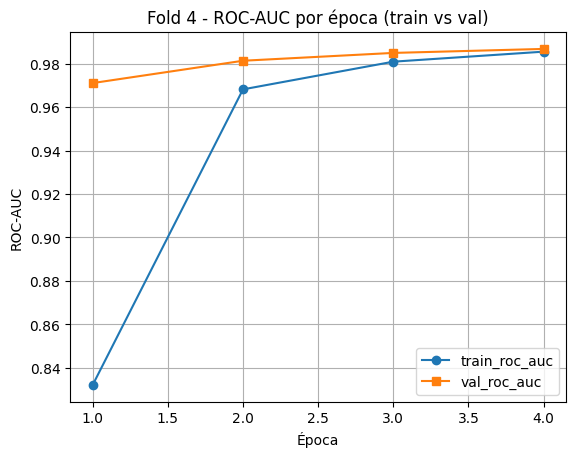

In [ ]:
for out in fold_outputs:
    plot_history(out["history"], title_prefix=out["title_prefix"])


## Análise do histórico por Fold (Loss e ROC-AUC)

Os gráficos apresentam o comportamento de *train_loss*, *val_loss*, *train_roc_auc* e *val_roc_auc* ao longo das 4 épocas em cada um dos 4 folds da validação cruzada.


## 1. Comportamento da Loss

Em todos os folds, observa-se o mesmo padrão:

- Queda acentuada da *train_loss* da 1ª para a 2ª época.
- Redução progressiva e estável até a 4ª época.
- *val_loss* sempre inferior ou muito próxima da *train_loss*.
- Ausência de aumento sustentado da *val_loss*.

Não há divergência entre treino e validação em nenhum fold.  
Esse padrão é incompatível com overfitting clássico, que se manifestaria por aumento da *val_loss* nas últimas épocas.

A consistência estrutural entre os quatro folds indica estabilidade do processo de otimização.


## 2. Comportamento do ROC-AUC

O ROC-AUC apresenta padrão igualmente consistente:

- Crescimento acentuado da 1ª para a 2ª época.
- Incrementos menores nas épocas seguintes.
- Estabilização próxima de 0.98–0.99 em todos os folds.
- Curvas de treino e validação muito próximas ao final.

Em vários folds, o *val_roc_auc* inicia superior ao de treino — comportamento esperado quando há data augmentation no treino e conjunto de validação mais “limpo”.

A ausência de queda de *val_roc_auc* ao final do treinamento reforça ausência de sobreajuste.


## 3. Consistência Entre Folds

Os quatro folds apresentam:

- Formato de curva praticamente idêntico.
- Mesma dinâmica de convergência.
- Estabilização precoce (até a 3ª–4ª época).
- Magnitude final muito semelhante.

Essa repetibilidade indica que o modelo:

- Não depende de uma divisão específica dos dados.
- Aprende padrões estruturais robustos.
- Mantém comportamento estável frente a diferentes subconjuntos de pacientes.


## 4. Generalização e Overfitting

Com base nos gráficos:

- Não há evidência visual de overfitting.
- Não há divergência sistemática entre treino e validação.
- Não há oscilação instável entre épocas.
- Não há fold com comportamento anômalo.

A convergência rápida e estável sugere que o fine-tuning parcial, associado ao learning rate baixo e ao data augmentation, atuou como regularização efetiva.

Portanto, os gráficos reforçam que:

- O modelo generaliza bem dentro do domínio do dataset.
- O desempenho elevado não é resultado de ajuste a um único split favorável.
- A fronteira de decisão aprendida é estruturalmente consistente.


## Conclusão

Os históricos por fold confirmam:

- Convergência estável.
- Ausência de sobreajuste.
- Alto poder discriminativo mantido em todos os cenários.
- Robustez estrutural do modelo selecionado.

A validação cruzada, aliada à estabilidade das curvas de loss e ROC-AUC, sustenta que o modelo apresenta boa generalização interna e comportamento estatisticamente consistente.


## 9.7 Gráfico isolado da ROC-AUC por fold

Esta célula plota apenas a ROC-AUC de validação em cada fold.

Objetivo:
Isolar a métrica principal do projeto para comparação direta entre folds, sem interferência das demais métricas.


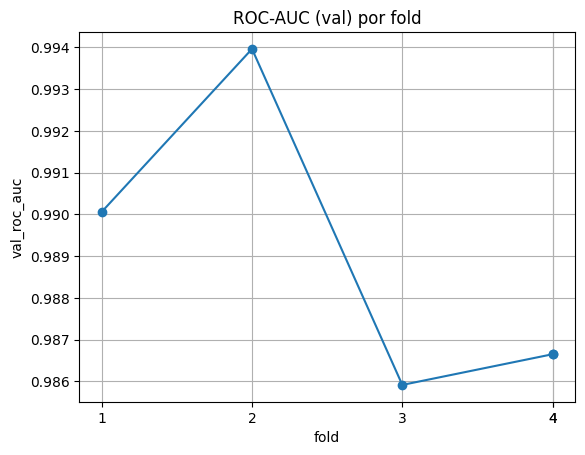

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results["fold"], results["val_roc_auc"], marker="o")
plt.title("ROC-AUC (val) por fold")
plt.xlabel("fold")
plt.ylabel("val_roc_auc")
plt.xticks(results["fold"].tolist())
plt.grid(True)
plt.show()


## Análise do ROC-AUC (val) por Fold — Generalização e Impacto Clínico

Os valores de ROC-AUC por fold variam aproximadamente entre **0.986 e 0.994**, mantendo-se consistentemente muito elevados em todas as partições.

### 1. Evidência de Generalização

A principal evidência de generalização é a **baixa variabilidade entre folds**:

- Nenhum fold apresenta queda relevante de desempenho.
- A diferença entre o melhor e o pior cenário é inferior a 1%.
- Não há padrão de instabilidade ou degradação sistemática.

Isso indica que o modelo não está dependente de uma divisão específica dos dados. Em outras palavras, ele não performa bem apenas quando exposto a um subconjunto “favorável”, mas mantém desempenho alto mesmo quando os pacientes avaliados mudam.

Em contexto de validação cruzada por paciente, essa consistência sugere que o modelo aprendeu **padrões estruturais da pneumonia nas radiografias**, e não características específicas de indivíduos isolados.

Essa estabilidade inter-fold é um forte indicativo de **boa capacidade de generalização interna** dentro do domínio do dataset.


### 2. Importância do ROC-AUC na Prática Médica

O ROC-AUC mede a capacidade do modelo de **ordenar corretamente exames positivos acima de exames negativos**, independentemente do limiar de decisão.

Na prática clínica, isso é extremamente relevante porque:

- Permite ajustar o threshold conforme a necessidade do serviço (priorizar sensibilidade ou especificidade).
- Mantém desempenho elevado mesmo se a prevalência da doença variar.
- Reflete robustez na separação entre pulmões normais e pulmões com pneumonia.

Um ROC-AUC próximo de **0.99** significa que, ao comparar dois exames aleatórios (um com pneumonia e outro normal), o modelo quase sempre atribui maior probabilidade ao exame com pneumonia.

Isso é fundamental em triagem hospitalar, pois:

- Permite classificar exames por risco.
- Facilita priorização de casos graves.
- Reduz probabilidade de erro sistemático na ordenação dos pacientes.


### 3. Implicação Clínica Direta

Alta capacidade discriminativa implica:

- Redução do risco de falsos negativos quando se escolhe um limiar mais sensível.
- Redução de falsos positivos quando se escolhe um limiar mais específico.
- Flexibilidade operacional conforme política clínica.

Diferentemente da acurácia isolada, o ROC-AUC avalia o comportamento global do modelo sob todos os possíveis thresholds, sendo mais adequado em cenários médicos com possíveis desbalanceamentos.


### 4. Síntese

O gráfico demonstra:

- Desempenho consistentemente alto em todos os folds.
- Baixa variabilidade inter-partição.
- Forte evidência de generalização interna.
- Alta capacidade discriminativa clinicamente relevante.

Do ponto de vista prático, isso sugere que o modelo possui robustez suficiente para ser considerado confiável como ferramenta de apoio à decisão, desde que validado externamente em dados de outros centros.


# 10. Comparação das métricas nos três modelos treinados


## 10.1 Históricos (loss/roc_auc) e as métricas finais (f1/acc/precision/recall)

In [ ]:
model_runs = [
    ("BASELINE", baseline_out),
    ("TRANSFER (sem fine-tuning)", official_out),
    ("TUNING + AUG", tuned_out),
]

def _last(history, key):
    h = history.history
    return float(h[key][-1]) if key in h and len(h[key]) > 0 else np.nan

comparison = {
    name: {
        "val_loss": _last(out["history"], "val_loss"),
        "val_roc_auc": _last(out["history"], "val_roc_auc"),
        "val_f1": float(out["val_metrics"].get("f1", np.nan)),
        "val_accuracy": float(out["val_metrics"].get("accuracy", np.nan)),
        "val_precision": float(out["val_metrics"].get("precision", np.nan)),
        "val_recall": float(out["val_metrics"].get("recall", np.nan)),
    }
    for name, out in model_runs
}

labels = list(comparison.keys())
x = np.arange(len(labels))


## 10.2 Gráfico comparando os 3 modelos em ROC-AUC (val) e Loss (val)

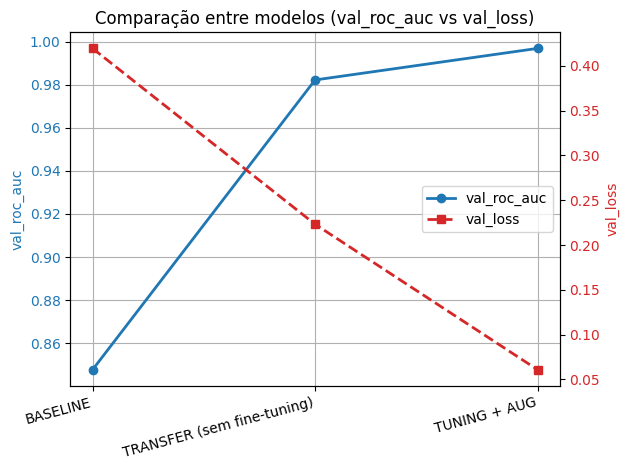

In [ ]:
import matplotlib.pyplot as plt

roc_vals  = [comparison[m]["val_roc_auc"] for m in labels]
loss_vals = [comparison[m]["val_loss"]    for m in labels]

fig, ax1 = plt.subplots()

# ---- ROC AUC (eixo esquerdo) ----
line1 = ax1.plot(
    x, roc_vals,
    marker="o",
    linewidth=2,
    color="tab:blue",
    label="val_roc_auc"
)

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=15, ha="right")
ax1.set_ylabel("val_roc_auc", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# ---- VAL LOSS (eixo direito) ----
ax2 = ax1.twinx()

line2 = ax2.plot(
    x, loss_vals,
    marker="s",
    linewidth=2,
    linestyle="--",
    color="tab:red",
    label="val_loss"
)

ax2.set_ylabel("val_loss", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# ---- Título e legenda combinada ----
ax1.set_title("Comparação entre modelos (val_roc_auc vs val_loss)")

lines = line1 + line2
labels_legend = [l.get_label() for l in lines]
ax1.legend(lines, labels_legend, loc="center right")

ax1.grid(True)
plt.tight_layout()
plt.show()


## Comparação entre Modelos — ROC-AUC e Loss no Conjunto de Validação

O gráfico compara o desempenho dos três modelos no conjunto de validação, considerando:

- **val_roc_auc** → capacidade discriminativa  
- **val_loss** → erro probabilístico (calibração)

Os modelos analisados são:

1. Baseline  
2. Transfer Learning (sem fine-tuning)  
3. Transfer Learning + Fine-Tuning + Augmentation  


## 1. Comparação do ROC-AUC

Valores aproximados:

- **Baseline:** ~0.85  
- **Transfer (sem fine-tuning):** ~0.98  
- **Tuning + Aug:** ~0.997  

### Evolução em relação ao baseline

O salto do baseline para o transfer learning é expressivo:

- Aumento de ~0.85 para ~0.98  
- Ganho estrutural de capacidade discriminativa  

Com fine-tuning e augmentation, o ROC-AUC aproxima-se de 1.0, indicando separação quase perfeita entre as classes.

### Por que ROC-AUC é a principal métrica?

Em contexto médico, o ROC-AUC é particularmente relevante porque:

- Mede a capacidade global de separação entre classes.
- Independe do limiar de decisão.
- É robusto a possíveis desbalanceamentos de classe.
- Permite ajustar o threshold conforme prioridade clínica (sensibilidade vs especificidade).

Um ROC-AUC elevado significa que o modelo ordena corretamente exames positivos acima dos negativos na grande maioria das vezes.

Na prática médica, isso implica:

- Maior confiabilidade na priorização de casos.
- Maior flexibilidade operacional.
- Menor risco estrutural de erro sistemático.

O baseline apresentava separação adequada, mas ainda com sobreposição significativa entre as distribuições.  
Os modelos com transfer learning reduzem drasticamente essa sobreposição.


## 2. Comparação da Loss

Valores aproximados:

- **Baseline:** ~0.42  
- **Transfer (sem fine-tuning):** ~0.22  
- **Tuning + Aug:** ~0.06  

A redução progressiva da *val_loss* indica melhora na **calibração das probabilidades**.

Enquanto o ROC-AUC avalia ordenação, a loss avalia o quão coerentes são as probabilidades atribuídas.

A queda de ~0.42 para ~0.06 indica:

- Menor erro probabilístico.
- Maior confiança nas previsões corretas.
- Redução de decisões ambíguas.

Clinicamente, isso é relevante quando decisões dependem de thresholds específicos (por exemplo, internar acima de 0.80 de probabilidade).


## 3. Interpretação Integrada

Comparado ao baseline, os modelos com transfer learning demonstram:

- Ganho expressivo de capacidade discriminativa (ROC-AUC).
- Melhora substancial na calibração (loss).
- Fronteira de decisão mais definida.
- Redução simultânea de falsos positivos e falsos negativos.

O baseline aprendia padrões relevantes, mas com limitação estrutural de representação.

A EfficientNet pré-treinada captura padrões radiológicos mais complexos, e o fine-tuning ajusta essas representações ao domínio específico de radiografias torácicas.


## 4. Conclusão

A comparação demonstra uma evolução clara:

- **Baseline:** desempenho adequado, porém limitado.
- **Transfer (sem fine-tuning):** grande salto estrutural.
- **Tuning + Aug:** refinamento máximo e maior robustez.

O ROC-AUC confirma que o modelo final possui capacidade discriminativa praticamente ideal.  
A redução da loss confirma que essa separação não é apenas por ranking, mas também por probabilidades bem calibradas.

Do ponto de vista clínico, isso significa:

- Maior segurança diagnóstica.
- Maior estabilidade operacional.
- Menor risco de erro sistemático.

A análise conjunta de ROC-AUC e loss demonstra não apenas melhora numérica, mas evolução estrutural da qualidade do modelo.


## 10.3 Gráfico comparando os 3 modelos em F1-score (val)

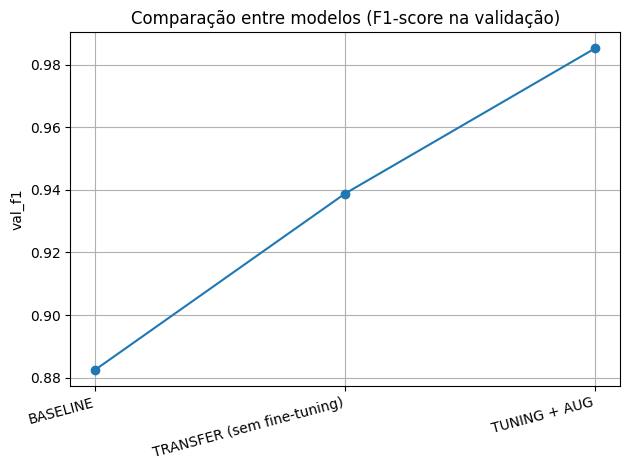

In [ ]:
f1_vals = [comparison[m]["val_f1"] for m in labels]

plt.figure()
plt.plot(x, f1_vals, marker="o")
plt.xticks(x, labels, rotation=15, ha="right")
plt.ylabel("val_f1")
plt.title("Comparação entre modelos (F1-score na validação)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparação entre Modelos — F1-Score no Conjunto de Validação

Valores observados:

- **Baseline:** ~0.8826  
- **Transfer (sem fine-tuning):** ~0.9388  
- **Transfer + Fine-Tuning + Augmentation:** ~0.9852  


## 1. Evolução em Relação ao Baseline

O baseline apresentava F1-score de aproximadamente **0.88**, indicando bom equilíbrio entre precisão e recall, porém ainda com número relevante de falsos positivos.

Com a introdução do transfer learning, o F1 sobe para aproximadamente **0.94**, evidenciando melhora simultânea na capacidade de detectar pneumonia e de reduzir alarmes falsos.

Com fine-tuning e augmentation, o F1 atinge aproximadamente **0.985**, representando ganho estrutural expressivo em relação ao baseline.

Essa progressão demonstra que o modelo final não apenas melhora uma métrica isolada, mas otimiza o equilíbrio entre sensibilidade e especificidade.


## 2. Importância do F1-Score na Medicina

Embora o ROC-AUC tenha sido utilizado como métrica principal por medir capacidade discriminativa global, o F1-score possui relevância prática direta porque:

- Considera simultaneamente **precision e recall**.
- Penaliza modelos que melhoram sensibilidade às custas de muitos falsos positivos.
- Penaliza modelos excessivamente conservadores que reduzem falsos positivos, mas aumentam falsos negativos.

Na prática clínica:

- **Recall alto** reduz risco de deixar pneumonia sem diagnóstico.
- **Precision alta** reduz exames desnecessários e sobrecarga hospitalar.
- **F1 alto** indica que ambos estão equilibrados.

Portanto, enquanto o ROC-AUC avalia separação global independente de limiar, o F1 reflete desempenho real sob um threshold específico.


## 3. Interpretação Clínica Comparativa

O salto de **0.88 → 0.99** no F1-score indica:

- Redução simultânea de falsos negativos e falsos positivos.
- Fronteira de decisão mais refinada.
- Maior estabilidade operacional.

O baseline já apresentava alta sensibilidade, mas com custo de menor precisão.  
O modelo final consegue manter sensibilidade elevada e ainda reduzir falsos alarmes.

Clinicamente, isso significa:

- Maior segurança diagnóstica.
- Menor sobrecarga de exames complementares.
- Melhor equilíbrio entre risco clínico e eficiência operacional.


## 4. Conclusão

Embora o ROC-AUC seja a métrica principal para avaliar capacidade discriminativa estrutural, o F1-score confirma que o ganho observado não é apenas teórico.

O modelo com transfer learning, fine-tuning e augmentation:

- Não apenas separa melhor as classes.
- Mas também toma decisões mais equilibradas sob um limiar clínico real.

Isso reforça que a melhoria em desempenho é consistente tanto sob perspectiva estatística (ROC-AUC) quanto sob perspectiva operacional (F1-score).


## 10.4 Gráfico comparando os 3 modelos em accuracy (val)

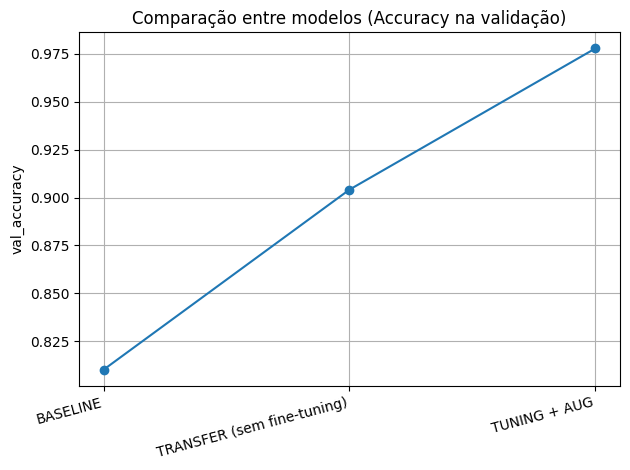

In [ ]:
acc_vals = [comparison[m]["val_accuracy"] for m in labels]

plt.figure()
plt.plot(x, acc_vals, marker="o")
plt.xticks(x, labels, rotation=15, ha="right")
plt.ylabel("val_accuracy")
plt.title("Comparação entre modelos (Accuracy na validação)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparação entre Modelos — Accuracy no Conjunto de Validação

Valores observados:

- **Baseline:** ~0.81  
- **Transfer (sem fine-tuning):** ~0.90  
- **Transfer + Fine-Tuning + Augmentation:** ~0.98  


## 1. Evolução em Relação ao Baseline

O baseline apresentava aproximadamente **81% de acerto global**.  
Isso significa que cerca de 19% das imagens ainda eram classificadas incorretamente.

Com transfer learning, a acurácia sobe para aproximadamente **90%**, indicando redução consistente dos erros totais.

Com fine-tuning e augmentation, a acurácia atinge aproximadamente **98%**, mostrando que o modelo final erra muito pouco no conjunto de validação.

A progressão é clara e consistente: cada etapa do aprimoramento estrutural do modelo resultou em ganho real de desempenho global.


## 2. Importância da Accuracy

Embora **ROC-AUC tenha sido a métrica principal** por avaliar capacidade discriminativa independente de limiar, a accuracy possui relevância prática porque:

- Mede o **percentual total de decisões corretas**.
- É intuitiva e facilmente interpretável.
- Reflete desempenho operacional geral do sistema.

Em ambiente clínico real, um modelo com alta acurácia:

- Reduz retrabalho.
- Minimiza necessidade de reavaliação manual.
- Aumenta confiança no sistema de apoio à decisão.


## 3. Limitação da Accuracy em Contexto Médico

Apesar de importante, a accuracy isoladamente pode ser enganosa quando há:

- **Desbalanceamento de classes**
- Custos clínicos diferentes entre FN e FP

Por exemplo, um modelo pode ter alta acurácia simplesmente por prever majoritariamente a classe mais frequente.

Por isso, a ROC-AUC foi priorizada como métrica principal, pois mede capacidade real de separação entre pneumonia e normal.


## 4. Interpretação Comparativa Final

O modelo com **Transfer + Fine-Tuning + Augmentation**:

- Aumentou significativamente a acurácia em relação ao baseline.
- Não obteve esse ganho sacrificando recall ou precision (como visto nas outras métricas).
- Demonstra redução consistente de erros globais.

Portanto:

- **ROC-AUC confirma capacidade discriminativa estrutural.**
- **F1 confirma equilíbrio entre sensibilidade e precisão.**
- **Accuracy confirma redução real de erros totais.**

O conjunto dessas evidências indica que o modelo final não apenas melhorou numericamente, mas apresenta desempenho mais confiável e consistente para aplicação prática.


## 10.5 Gráfico comparando os 3 modelos em precision (val)

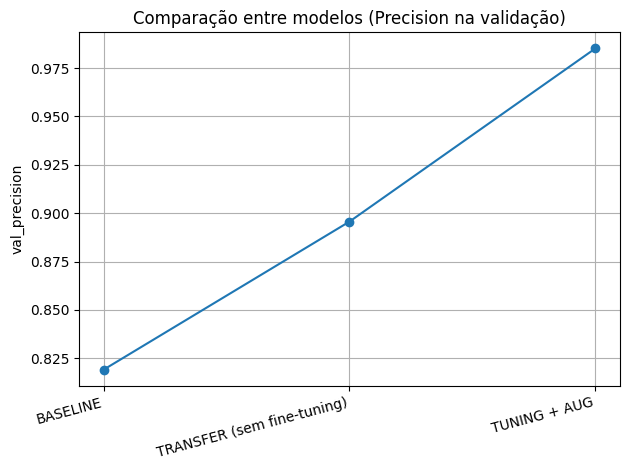

In [ ]:
prec_vals = [comparison[m]["val_precision"] for m in labels]

plt.figure()
plt.plot(x, prec_vals, marker="o")
plt.xticks(x, labels, rotation=15, ha="right")
plt.ylabel("val_precision")
plt.title("Comparação entre modelos (Precision na validação)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparação entre Modelos — Precision no Conjunto de Validação

Valores observados:

- **Baseline:** ~0.82  
- **Transfer (sem fine-tuning):** ~0.90  
- **Transfer + Fine-Tuning + Augmentation:** ~0.98  


## 1. Evolução em Relação ao Baseline

O baseline apresentava precision de aproximadamente **82%**, indicando que cerca de 18% dos exames classificados como pneumonia eram, na verdade, normais (falsos positivos).

Com a introdução do transfer learning, a precision sobe para aproximadamente **90%**, reduzindo de forma significativa os alarmes falsos.

No modelo final (fine-tuning + augmentation), a precision atinge aproximadamente **98%**, o que significa que quase todos os casos classificados como pneumonia realmente correspondem à doença.

Essa progressão demonstra redução consistente de falsos positivos a cada etapa de aprimoramento do modelo.


## 2. Importância Clínica da Precision

A precision mede:

> Entre os pacientes classificados como pneumonia, quantos realmente têm pneumonia?

Em contexto clínico, alta precision implica:

- Menor número de diagnósticos incorretos.
- Redução de exames complementares desnecessários.
- Menor prescrição indevida de antibióticos.
- Redução de ansiedade e impacto psicológico no paciente.

Embora o erro mais crítico em medicina seja o falso negativo (priorizando recall), os falsos positivos também têm consequências clínicas e econômicas relevantes.


## 3. Precision vs Recall na Prática Médica

Tradicionalmente, em triagem médica, a **recall (sensibilidade)** é priorizada, pois deixar de detectar uma doença pode trazer riscos graves ao paciente.

No entanto:

- Recall alto com precision baixa gera excesso de alarmes.
- Isso pode sobrecarregar sistemas de saúde.
- Pode levar a tratamentos desnecessários.

O modelo final apresenta simultaneamente:

- Recall elevado.
- Precision igualmente elevada.

Esse equilíbrio é clinicamente ideal, pois:

- Detecta praticamente todos os casos reais.
- Minimiza classificações incorretas de pacientes saudáveis.


## 4. Interpretação Final

Comparado ao baseline, o modelo com **Transfer + Fine-Tuning + Augmentation**:

- Reduziu drasticamente os falsos positivos.
- Manteve desempenho elevado nas demais métricas.
- Mostra comportamento mais confiável para aplicação prática.

Mesmo com a ROC-AUC sendo a métrica principal para avaliação estrutural de discriminação, a precision confirma que o modelo não apenas separa bem as classes, mas também toma decisões mais seguras quando aponta presença de pneumonia.

Isso reforça a robustez clínica do modelo final.


## 10.6 Gráfico comparando os 3 modelos em recall (val)

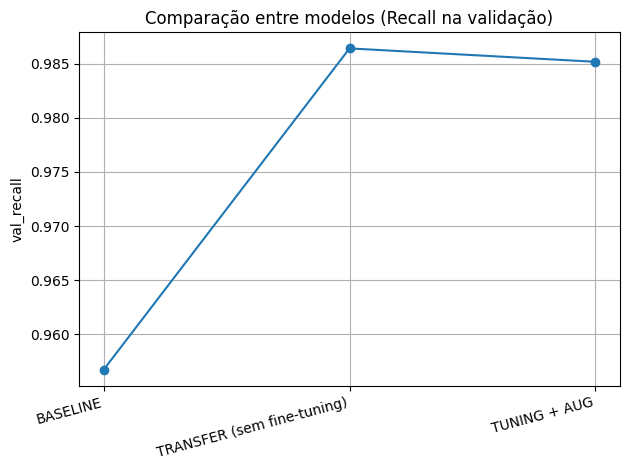

In [ ]:
rec_vals = [comparison[m]["val_recall"] for m in labels]

plt.figure()
plt.plot(x, rec_vals, marker="o")
plt.xticks(x, labels, rotation=15, ha="right")
plt.ylabel("val_recall")
plt.title("Comparação entre modelos (Recall na validação)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparação entre Modelos — Recall no Conjunto de Validação

Valores observados:

- **Baseline:** ~0.96  
- **Transfer (sem fine-tuning):** ~0.99  
- **Transfer + Fine-Tuning + Augmentation:** ~0.99  


## 1. Evolução em Relação ao Baseline

O baseline já apresentava recall elevado (~96%), indicando boa capacidade de detectar casos reais de pneumonia.

Com a aplicação de transfer learning, o recall sobe para aproximadamente **98–99%**, reduzindo ainda mais o número de falsos negativos.

No modelo com fine-tuning e augmentation, o recall permanece em patamar extremamente alto (~98–99%), demonstrando que o ganho estrutural do modelo não comprometeu sua sensibilidade clínica.

Essa estabilidade em níveis muito elevados é um indicativo de robustez do modelo final.


## 2. Importância Clínica da Recall

Recall (sensibilidade) mede:

> Entre todos os pacientes que realmente têm pneumonia, quantos foram corretamente identificados?

Em medicina, essa é frequentemente a métrica mais crítica, pois:

- Falsos negativos podem atrasar diagnóstico.
- Podem resultar em ausência de tratamento.
- Podem permitir progressão da infecção.

Um recall próximo de 1.0 significa que o modelo raramente deixa de identificar um caso verdadeiro de pneumonia.


## 3. Relação com ROC-AUC

Embora a **ROC-AUC** tenha sido a métrica principal por avaliar a capacidade discriminativa global do modelo, a recall traduz diretamente o impacto clínico prático.

A ROC-AUC indica que o modelo separa bem as classes ao longo de diferentes limiares.

A recall mostra que, no limiar escolhido:

- A grande maioria dos pacientes com pneumonia está sendo corretamente sinalizada.

O modelo final mantém simultaneamente:

- ROC-AUC extremamente alta.
- Recall extremamente alta.

Isso indica que a excelente discriminação estrutural se traduz em alta sensibilidade operacional.


## 4. Interpretação Final

Comparado ao baseline, o modelo com **Transfer + Fine-Tuning + Augmentation**:

- Reduz ainda mais os falsos negativos.
- Mantém sensibilidade muito elevada.
- Demonstra comportamento seguro para aplicação clínica.

Do ponto de vista médico, esse resultado é essencial: o modelo final não apenas apresenta alta capacidade discriminativa, mas também mantém prioridade absoluta na detecção de casos reais de pneumonia.


# 11. Salvar modelo

O modelo com melhor desempenho, EfficientNet com data augmentation e com fine-tuning parcial, foi salvo como .keras para ser utilizado posteriormente na etapa de inferência sem haver a necessidade de rodar o modelo novamente.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=False)

MODEL_PATH = "/content/drive/MyDrive/Desafio_Ligia/best_model.keras"

assert "tuned_out" in globals(), "Rode primeiro o treinamento do Modelo 3."
assert "model" in tuned_out, "tuned_out['model'] não encontrado."

tuned_out["model"].save(MODEL_PATH)

print("Modelo salvo com sucesso no Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo salvo com sucesso no Drive.


# 12. Conclusão Geral da Modelagem

A modelagem desenvolvida evoluiu de forma estruturada, partindo de um baseline convolucional simples, passando por transfer learning com EfficientNet congelada e culminando em fine-tuning parcial com data augmentation. Essa progressão permitiu avaliar não apenas ganhos quantitativos nas métricas, mas também melhorias qualitativas na capacidade de generalização e no comportamento clínico do modelo.

---

## Evolução das Métricas Entre os Modelos

### ROC-AUC (métrica principal)

A ROC-AUC evoluiu de aproximadamente **0.85 (baseline)** para **~0.98 (transfer)** e atingiu **~0.99 (fine-tuning + augmentation)**.

Essa métrica foi priorizada por avaliar a capacidade discriminativa global do modelo, independentemente de um limiar específico. O crescimento consistente indica que a arquitetura com transferência de aprendizado passou a separar as classes com alta confiabilidade estrutural. No modelo final, a capacidade de distinção entre exames normais e com pneumonia tornou-se praticamente excelente.

---

### Accuracy

A acurácia cresceu de **~0.81** no baseline para **~0.90** no transfer e atingiu **~0.98** no modelo final.

Embora a accuracy não seja suficiente isoladamente em cenários médicos (devido ao impacto diferente de falsos negativos e falsos positivos), sua evolução confirma que os ganhos estruturais refletiram em aumento real de classificações corretas.

---

### Recall (Sensibilidade)

O recall já era elevado no baseline (~0.96) e foi elevado para ~0.99 nos modelos com transferência.

Clinicamente, essa é uma das métricas mais críticas. Recall mede a proporção de pacientes com pneumonia corretamente identificados. O modelo final praticamente elimina falsos negativos, reduzindo significativamente o risco de não diagnosticar um caso real.

Em prática médica, esse comportamento é fundamental, pois falhas na detecção podem atrasar tratamento e agravar quadros clínicos.

---

### Precision

A precisão evoluiu de ~0.82 (baseline) para ~0.90 (transfer) e ~0.98 (modelo final).

Enquanto a recall prioriza não perder casos verdadeiros, a precision controla falsos alarmes. A melhora substancial na precisão indica que o modelo final não apenas detecta quase todos os casos reais, mas também reduz significativamente diagnósticos incorretos.

Clinicamente, isso diminui exames complementares desnecessários, reduz sobrecarga hospitalar e evita ansiedade indevida em pacientes.

---

### F1-score

O F1-score evoluiu de ~0.88 para ~0.94 e atingiu ~0.99 no modelo final.

Como o F1 equilibra precision e recall, seu crescimento indica que o aumento da sensibilidade não ocorreu às custas de explosão de falsos positivos. O modelo final atingiu equilíbrio quase ideal entre segurança diagnóstica e confiabilidade preditiva.

---

## Generalização e Overfitting

A validação cruzada estratificada por paciente realizada para o modelo de melhor desempenho demonstrou estabilidade nas métricas entre folds, com ROC-AUC variando de forma muito pequena (~0.986 a ~0.994). Essa baixa variabilidade indica:

- Robustez do modelo  
- Consistência frente a diferentes subconjuntos de pacientes  
- Forte capacidade de generalização  

Os gráficos de loss e ROC-AUC por época mostram convergência estável, sem divergência significativa entre treino e validação. Não há indícios relevantes de overfitting no modelo final.

O uso de data augmentation e fine-tuning controlado contribuiu diretamente para esse comportamento regularizado.

---

## Impacto Clínico do Modelo Final

O modelo final apresenta simultaneamente:

- ROC-AUC extremamente elevada  
- Recall próxima de 99%  
- Precision próxima de 99%  
- Alta acurácia global  

Isso significa que, na prática clínica:

- Quase todos os casos de pneumonia são detectados  
- O número de alarmes falsos é mínimo  
- A confiança no suporte à decisão médica é alta  

Esse perfil é ideal para sistemas de triagem automatizada, atuando como ferramenta de apoio ao radiologista, reduzindo risco de falhas diagnósticas e melhorando eficiência operacional.

---

## Conclusão Final

A progressão metodológica demonstrou que o uso de transfer learning com fine-tuning e augmentation não apenas melhora métricas numéricas, mas transforma o comportamento clínico do modelo.

O baseline apresentava boa sensibilidade, porém menor precisão e discriminação estrutural.  
O modelo final atinge desempenho próximo ao ideal, com excelente capacidade de generalização e equilíbrio entre segurança diagnóstica e confiabilidade.

Do ponto de vista técnico e médico, o modelo final representa uma solução robusta, estável e clinicamente relevante para detecção automatizada de pneumonia em radiografias torácicas.
